# 0. Introducción

El objetivo final de la práctica es predecir el precio de las viviendas de AirBnB de la ciudad de **Madrid** a partir de un dataset que se encuentra [aquí](https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&q=Madrid&timezone=Europe/Berlin&lang=en&use_labels_for_header=true&csv_separator=%3B). Se ha optado por una dataset parcial de 14780 registros 

# 1. Librerías principales, opciones y funciones generales

## 1.1 Librerías principales y opciones

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

# Por defecto mostramos todas las columnas y filas de los datasets
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## 1.2 Funciones generales
Funciones que se va a utilizar varias veces a lo largo del notebook. Se evita la repetición de la declaración de arrays.

In [2]:
def get_non_essential_columns():
    return  [
        'Last Scraped','Name','Summary','Space','Description'
        ,'Neighborhood Overview','Notes','Transit','Access'
        ,'Interaction','House Rules','Host Name'
        ,'Host ID','Host About','Host Listings Count'
        ,'Host Total Listings Count','Calculated host listings count'
        ,'Host Location','Host Neighbourhood','Weekly Price','Monthly Price'
        ,'Calendar Updated','Calendar last Scraped','First Review'
        ,'Last Review','Reviews per Month'
    ]

In [3]:
def get_not_madrid(df):
    return df[(df['City'] != "Madrid") & (df['City'] != "MADRID") ].index

In [4]:
def get_columns_with_missing_values():
    return ['Host Acceptance Rate', 'Square Feet', 'Has Availability', 'License', 'Jurisdiction Names']

In [5]:
def get_redundant_columns():
    return ['Geolocation', 'State', 'Market', 'Smart Location'
     , 'Country', 'Country Code', 'Street', 'Zipcode', 'Neighbourhood'
     , 'Neighbourhood Group Cleansed','City']

In [6]:
def get_correlated_columns():
    return ['Accommodates', 'Availability 30', 'Availability 60'
            , 'Availability 90', 'Review Scores Rating', 'Review Scores Accuracy'
            , 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication'
            , 'Review Scores Location']

In [7]:
def remove_numeric_outliers(df_outliers):
    df = df_outliers[(df_outliers['Price'] <= 300)] # Se borran también los valores nulo
    df = df[(df['Security Deposit'] <= 650) | (df['Security Deposit'].isnull())]
    df = df[(df['Cleaning Fee'] <= 150) | (df['Cleaning Fee'].isnull())]
    df = df[(df['Extra People'] <= 50) | (df['Extra People'].isnull())]
    df = df[(df['Minimum Nights'] <= 365) | (df['Minimum Nights'].isnull())]
    df = df[(df['Maximum Nights'] <= 1125) | (df['Maximum Nights'].isnull())]
    return df

In [8]:
def fillna_with_zero(df):
    df['Security Deposit'].fillna(0, inplace=True)
    df['Cleaning Fee'].fillna(0, inplace=True)
    df['Host Response Rate'].fillna(0, inplace=True)
    return df

In [9]:
mean_Bathrooms = 0
mean_Bedrooms = 0
mean_Beds = 0
mean_Review_Scores_Value = 0

def fillna_with_means(df):
    df['Bathrooms'].fillna(mean_Bathrooms, inplace=True)
    df['Bedrooms'].fillna(mean_Bedrooms, inplace=True)
    df['Beds'].fillna(mean_Beds, inplace = True)
    df['Review Scores Value'].fillna(mean_Review_Scores_Value, inplace = True)
    
    return df

In [10]:
def dropna_in_host_since(df_host_since) :
    df = df_host_since.dropna(subset=['Host Since'])
    return df

In [11]:
def fillna_with_empty_string(df):
    df['Host Verifications'].fillna("", inplace=True)
    df['Amenities'].fillna("", inplace=True)
    df['Features'].fillna("", inplace=True) # esta caso no haría falta, pero se pone por si aparece un dataset,
                                            # en el que sí haga falta
    return df # se podría evitar el return

In [12]:
mode_Host_Response_Time=""
def fillna_Host_Response_Time_with_its_mode(df):
    df['Host Response Time'].fillna(mode_Host_Response_Time, inplace=True)
    return df

In [13]:
def get_empty_columns():
    return ['Experiences Offered']

In [14]:
mean_price_map = {}
overall_mean_price = 0
def get_categorical_variables():
    return ['Host Response Time', 'Neighbourhood Cleansed', 'Property Type'
                         , 'Room Type', 'Bed Type', 'Cancellation Policy']

In [15]:
def mean_encoding_to_categorical_variables(df):
    for var in get_categorical_variables():
        # Media de precio por variable categórica
        df[var] = df[var].map(mean_price_map[var])
        # Si hay una variable categórica que no existe en el mapa, asignamos precio medio
        df[var].fillna(overall_mean_price, inplace=True)

    return df

In [16]:
def count_elements_in_list(df_lists):
    lists = ['Amenities', 'Features', 'Host Verifications']
    for l in lists:
        df_lists[l] = df_lists[l].apply(lambda x: len(str(x).split(',')))
        
    return df_lists

In [17]:
from datetime import datetime
def calculate_years(df_cy):
    current_year = int(datetime.now().year)
    df_cy['Host Since'] = df_cy['Host Since'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
    df_cy['Years'] = df_cy['Host Since'].apply(lambda x: current_year - x.year)
    df_cy.drop(['Host Since'], axis=1, inplace=True) # Borramos la columna de Host Since

    return df_cy

In [18]:
def create_bed_bath_rooms(df):
    df['bed_bath_rooms'] = df['Bathrooms']*df['Bedrooms']
    
    return df

In [19]:
def create_bedrooms_squared(df):
    
    df['bedrooms_squared'] = df['Bedrooms']*df['Bedrooms']
    
    return df

In [20]:
# Se crea función para calcular distancias entre puntos geográficos en lugar de utilizar
# la ya existente en distintos paquetes para evitar dependencias
from math import sin, cos, sqrt, atan2, radians

def distance(glat1, glon1, glat2, glon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(glat1)
    lon1 = radians(glon1)
    lat2 = radians(glat2)
    lon2 = radians(glon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c


In [21]:
def mean_distance(df_points, latitude, longitude):
    return df_points.apply(lambda t: distance(t.latitude, t.longitude, latitude, longitude), axis=1).sum()/len(df_points)


In [22]:
def create_mean_touristic_distance(dfx, df_points):
    dfx['mean_touristic_distance'] = dfx.apply(lambda listing: mean_distance(df_points, listing.Latitude, listing.Longitude), axis=1)
    
    return dfx


In [23]:
# Función que deberá ser utilizada para aplicar las transformaciones al conjunto de test antes de validar el modelo
def drop_columns_and_filter_rows_in_test_set(df_test, df_points):
    
    # Eliminar columnas no esenciales
    dfx = df_test.drop(get_non_essential_columns(), axis=1)
    # Filtrar Madrid
    dfx.drop(get_not_madrid(dfx), axis=0, inplace=True)
    
    # Eliminar columnas con muchos valores missing
    dfx.drop(get_columns_with_missing_values(), axis=1, inplace=True)

    # Eliminar columnas redundantes
    dfx.drop(get_redundant_columns(), axis=1, inplace=True)
    
    # Eliminar columnas correlacionadas
    dfx.drop(get_correlated_columns(), axis=1, inplace=True)

    # Ponemos la columna precio la primera
    cols = dfx.columns.tolist()
    cols.insert(0, cols.pop(cols.index('Price')))
    dfx = dfx[cols]
    
    # Eliminar outlier de columnas numéricas
    dfx =  remove_numeric_outliers(dfx)
    
    # Rellenar NaNs con 0
    dfx = fillna_with_zero(dfx)

    # Rellenar NaNs con medias
    dfx = fillna_with_means(dfx)
    
    # Eliminar filas con Host Since nulo
    dfx = dropna_in_host_since(dfx)
    
    # Rellenar nulos con cadenas vacías en determinadas columnas que tienen listas
    # de valores separados por comas
    dfx = fillna_with_empty_string(dfx)
    
    # Rellenar con la moda los valores nulos de Host_Response_Time 
    dfx = fillna_Host_Response_Time_with_its_mode(dfx)
    
    # Borrar las columnas string (object) con muchos valores vacíos o equivalente
    dfx = dfx.drop(get_empty_columns(), axis=1)

    # Asignar precios medios por categoría
    dfx = mean_encoding_to_categorical_variables(dfx)  
    
    # Sustituir columnas con listas de valores por el número de elementos que hay en la lista
    dfx = count_elements_in_list(dfx)
    
    # Calcular los años de antigüedad que lleva la vivienda en Airbnb
    dfx = calculate_years(dfx)
    
    # Creamos nuevas características combinando otras ya existentes
    dfx = create_bed_bath_rooms(dfx)
    dfx = create_bedrooms_squared(dfx)
    dfx = create_mean_touristic_distance(dfx, df_points)
    
    return dfx
    

# 2. Carga de datos. Eliminación de características innecesarias.

## 2.1 Carga de datos y características básicas

In [24]:
full_df = pd.read_csv('./airbnb-listings-extract.csv', sep=';', decimal='.')

## 2.2 Inspección básica

In [25]:
print(f'Dimensiones del dataset completo: {full_df.shape}')

Dimensiones del dataset completo: (14780, 89)


In [26]:
# Inspeccionamos las columnas del dataset. Para facilitar la tarea hacemos un head transpuesto
full_df.head().T

0  \
ID                                                                       11210388   
Listing Url                                 https://www.airbnb.com/rooms/11210388   
Scrape ID                                                          20170306202425   
Last Scraped                                                           2017-03-07   
Name                                               The Loft-Full Bath-Deck w/View   
Summary                         Loft in the Hill country 12-15 minutes directl...   
Space                           This loft has a spectacular view of the hills ...   
Description                     Loft in the Hill country 12-15 minutes directl...   
Experiences Offered                                                          none   
Neighborhood Overview           This neighborhood is located in the hills west...   
Notes                           The loft is located on a gated property.  Ther...   
Transit                         There is no public transportation from this lo...   
Access                          The loft is entirely private to the guest as i...   
Interaction                     My wife and I live on the property so we would...   
House Rules                     The loft is entirely private but is adjacent t...   
Thumbnail Url                   https://a0.muscache.com/im/pictures/c351a9b5-5...   
Medium Url                      https://a0.muscache.com/im/pictures/c351a9b5-5...   
Picture Url                     https://public.opendatasoft.com/api/v2/catalog...   
XL Picture Url                  https://a0.muscache.com/im/pictures/c351a9b5-5...   
Host ID                                                                  58386783   
Host URL                               https://www.airbnb.com/users/show/58386783   
Host Name                                                                    John   
Host Since                                                             2016-02-11   
Host Location                   My father was USAF so I was born at Offutt AFB...   
Host About                      I am a High Tech Professional with over 30 yea...   
Host Response Time                                                 within an hour   
Host Response Rate                                                            100   
Host Acceptance Rate                                                          NaN   
Host Thumbnail Url              https://a0.muscache.com/im/pictures/c5c78f08-f...   
Host Picture Url                https://a0.muscache.com/im/pictures/c5c78f08-f...   
Host Neighbourhood                                                            NaN   
Host Listings Count                                                             1   
Host Total Listings Count                                                       1   
Host Verifications                                        email,phone,reviews,kba   
Street                          Canyon Edge Drive, Austin, TX 78733, United St...   
Neighbourhood                                                                 NaN   
Neighbourhood Cleansed                                                      78733   
Neighbourhood Group Cleansed                                                  NaN   
City                                                                       Austin   
State                                                                          TX   
Zipcode                                                                     78733   
Market                                                                     Austin   
Smart Location                                                         Austin, TX   
Country Code                                                                   US   
Country                                                             United States   
Latitude                                                                  30.3374   
Longitude                                                                -97.8633   


In [27]:
# Hacemos un dtype para saber los tipos de cada columna
full_df.dtypes

ID                                  int64
Listing Url                        object
Scrape ID                           int64
Last Scraped                       object
Name                               object
Summary                            object
Space                              object
Description                        object
Experiences Offered                object
Neighborhood Overview              object
Notes                              object
Transit                            object
Access                             object
Interaction                        object
House Rules                        object
Thumbnail Url                      object
Medium Url                         object
Picture Url                        object
XL Picture Url                     object
Host ID                             int64
Host URL                           object
Host Name                          object
Host Since                         object
Host Location                     

In [28]:
full_df['Price'].value_counts()

50.0     656
60.0     576
25.0     548
30.0     544
35.0     478
40.0     453
70.0     452
45.0     445
20.0     439
80.0     427
65.0     401
55.0     371
75.0     353
100.0    337
90.0     336
85.0     223
120.0    222
49.0     206
95.0     204
22.0     176
59.0     171
18.0     169
150.0    161
19.0     157
39.0     156
29.0     152
15.0     150
110.0    145
23.0     145
28.0     141
32.0     126
69.0     126
42.0     126
130.0    118
99.0     112
26.0     107
24.0     106
79.0     105
38.0     103
21.0     103
27.0     102
16.0      95
89.0      94
125.0     93
140.0     92
48.0      92
17.0      88
33.0      87
200.0     86
52.0      81
36.0      81
160.0     77
58.0      70
68.0      70
37.0      70
115.0     65
43.0      63
105.0     62
34.0      62
47.0      56
62.0      55
180.0     55
78.0      54
31.0      52
54.0      50
250.0     47
44.0      46
14.0      46
12.0      45
145.0     45
63.0      44
64.0      44
10.0      43
72.0      42
57.0      42
46.0      42
41.0      40

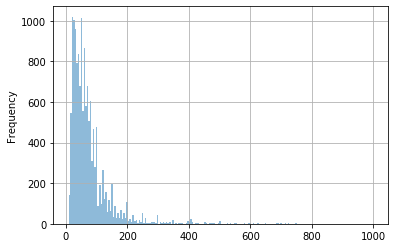

In [29]:
full_df['Price'].plot.hist(alpha=0.5, bins=200, grid = True)

In [30]:
full_df['Price'].describe()

count    14763.000000
mean        73.561471
std         72.062050
min          9.000000
25%         34.000000
50%         55.000000
75%         86.000000
max        999.000000
Name: Price, dtype: float64

## 2.3 Eliminación de características innecesarias
En este preanálisis se decide eliminar todas aquellas columnas que claramente no influyen en el precio de la vivienda, como columnas de tipo identificador, o aquellas que exigen un estudio más elaborado, como pueden las columnas de tipo URL. Es probable que de alguna de estas últimas columnas, accediendo a la página correspondiente, tal vez se pudiera derivar alguna característica (por ejemplo, alguna url, por el nombre de la columna, deducimos que son imágenes de la vivienda de las cuales se podría obtener información). La información que se pueden obtener de estas columnas no está en su contenido directo, sino que se debe acudir a otras fuentes relacionadas, y por tal razón, no se va abordar en esta práctica.

Así pues, las columnas que vamos a eliminar antes de comenzar el proceso de análisis son :

- ID: no está relacionado con el precido, ya que no indica nada sobre la vivienda
- Listing Url
- Scrape ID:  no está relacionado con el precido, ya que no indica nada sobre la vivienda
- Thumbnail Url
- Medium Url
- Picture Url
- XL Picture Url
- Host Url
- Host Thumbnail Url
- Host Picture Url

<div class = "alert alert-success">
TODO: En siguientes análisis deberían añadirse estas columnas en el proceso EDA, explicado en el siguiente punto, principalmente, las URL, y estudiar si de ellas se puede obtener alguna información.
</div>

In [31]:
drop_useless_columns = ['ID','Listing Url'
                        ,'Scrape ID','Thumbnail Url','Medium Url','Picture Url'
                        ,'XL Picture Url','Host URL','Host Thumbnail Url','Host Picture Url']
full_df.drop(drop_useless_columns, axis=1, inplace=True)
full_df.shape

(14780, 79)

# 3 Análisis exploratorio de datos (EDA). Exploraty Data Analysis

En primer lugar vamos a dividir el dataframe en train y test. El conjunto de datos de test NO lo utilizaremos en ningún momento a lo largo del análisis, excepto al final del proceso, para validar los modelos que se obtengan.

In [32]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(full_df, test_size=0.2, shuffle=True, random_state=0)

print(f'Dimensiones del dataset de training: {train.shape}')
print(f'Dimensiones del dataset de test: {test.shape}')

# Guardamos
train.to_csv('./train.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)

# A partir de este momento cargamos el dataset de train y trabajamos ÚNICAMENTE con él. 
df = pd.read_csv('./train.csv', sep=';', decimal='.')

Dimensiones del dataset de training: (11824, 79)
Dimensiones del dataset de test: (2956, 79)


## 3.1 Eliminación de características no esenciales

En este proceso vamos a eliminar columnas, pero previamente analizaremos superficialmente su contenido. Algunas de ellas serán eliminadas en un primer estudio que se hace en esta práctica, pero más adelante podrían ser recuperadadas y ser analizadas para incorporarlas, si fueran interesantes, a los modelos. 

In [33]:
df.head().T

0  \
Last Scraped                                                           2017-04-08   
Name                                             PISO ATOCHA- FLAT NEAR ATOCHA  .   
Summary                         Piso recién reformado cómoda habitación con ba...   
Space                           Un piso muy cómodo en Jerónimos, una de las zo...   
Description                     Piso recién reformado cómoda habitación con ba...   
Experiences Offered                                                          none   
Neighborhood Overview           El barrio de Jeronimos es un enclave tranquilo...   
Notes                           Facilitamos guía de eventos y rutas turísticas...   
Transit                         Excelente ubicación a tan solo 5 minutos andan...   
Access                          La conexión a internet por fibra óptica 100 MB...   
Interaction                     Recibimos personalmente a nuestros huéspedes y...   
House Rules                     El apartamento se encuentra en un edificio res...   
Host ID                                                                  31124866   
Host Name                                                                   Inava   
Host Since                                                             2015-04-13   
Host Location                           Arroyomolinos, Comunidad de Madrid, Spain   
Host About                                                                    NaN   
Host Response Time                                             within a few hours   
Host Response Rate                                                            100   
Host Acceptance Rate                                                          NaN   
Host Neighbourhood                                                      Jerónimos   
Host Listings Count                                                             2   
Host Total Listings Count                                                       2   
Host Verifications                                 email,phone,reviews,work_email   
Street                          Jerónimos, Madrid, Comunidad de Madrid 28014, ...   
Neighbourhood                                                           Jerónimos   
Neighbourhood Cleansed                                                  Jerónimos   
Neighbourhood Group Cleansed                                               Retiro   
City                                                                       Madrid   
State                                                         Comunidad de Madrid   
Zipcode                                                                     28014   
Market                                                                     Madrid   
Smart Location                                                      Madrid, Spain   
Country Code                                                                   ES   
Country                                                                     Spain   
Latitude                                                                  40.4077   
Longitude                                                                -3.68482   
Property Type                                                           Apartment   
Room Type                                                         Entire home/apt   
Accommodates                                                                    4   
Bathrooms                                                                       1   
Bedrooms                                                                        1   
Beds                                                                            2   
Bed Type                                                                 Real Bed   
Amenities                       TV,Internet,Wireless Internet,Air conditioning...   
Square Feet                                                                   NaN   
Price                                                                          60   


Revisando los valores de las columnas vemos que algunos valores de las mismas no aportan información relacionada con el precio. Podríamos agruparlos del siguiente modo:

- Valores de fecha que no están relacionados con el precio
- Columnas de tipo texto/descripción que exigirían la utilización de palabras clave (habría que recurrir a taxonomías y ontologías) para poder obtener a partir de ellas características nuevas. También algunos campos podrían ser analizamos mediante técnicas NLP. Algunas de estas columnas podrían ser recuperadas y analizadas de nuevo después de realizar el módulo de NLP del presente Bootcamp. En este momento se considera fuera de alcance por falta de conocimiento. En un entorno real de trabajo habría que considerarlas, ya que estas columnas podrían ofrecer información a través de su contenido de forma directa, aplicando las correspondiente técnicas.
<div class = "alert alert-success">
TODO: En el caso de las solución por palabras clave, podría ser parte del código que desarrolláramos el de la función getExpensiveWords que se encuentra <a href="https://github.com/peternmai/Airbnb_Price_Prediction/blob/master/AirBnB%20Price%20Prediction.ipynb" target="_blank">aquí</a>, y que relaciona cada palabra con el precio.
</div>
- Hay columnas cuyo contenido es redundante con repecto a otras columnas


En este sentido, las columnas que creemos que se deben borrar son:

- Last Scraped: la fecha en el que se hizo el scrape no está relacionada con el precio
- Name: el nombre no aporta información respecto al precio, o al menos exigiría tokenización
- Summary: exige tokenización y/o NLP
- Space: exige tokenización y/o NLP
- Description: exige tokenización y/o NLP
- Neighborhood Overview: exige tokenización y/o NLP
- Notes: exige tokenización y/o NLP
- Transit: exige tokenización y/o NLP
- Access: exige tokenización y/o NLP
- Interaction: exige tokenización y/o NLP
- House Rules: exige tokenización y/o NLP
- Host Name: no aporta información. Tal vez de algún estudio de marketing podría deducirse que un nombre llama más la atención que otro. En el caso de ser el nombre del dueño no aporta mucho. Hay otros datos del dueño, como Host Since, que aportan más información.
- Host ID: al igual que el nombre, el identificador del dueño no es relevante respecto al precio de la vivienda
- Host About: exige tokenización y/o NLP
- Host Listings Count: número de viviendas ofrecidas por el mismo dueño. Tal vez, en estudio posterior, se podría analizar si el mismo dueño rebaja el precio cuando tiene muchas viviendas, aunque no tendría por qué ser así. Descartamos esta columna.
- Host Total Listings Count: parece tener la misma información que la columna anterior. También la descartamos.
- Calculated host listings count: información relacionada con el dueño similar a las dos columnas anteriores. Se elimina.
- Host Location: es información redundante con otras columnas
- Host Neighbourhood: no aporta información el barrio del dueño.
- Weekly Price: puede ser un precio deducible o derivado del precio diario. Lo ignoramos por redundate.
- Weekly Price: puede ser un precio deducible o derivado del precio diario. Lo ignoramos por redundate.
- Calendar Updated: no tiene valor para predecir el precio
- Calendar last Scraped: lo eliminamos por la misma razón que Last Scraped
- First Review: no aporta información
- Last Review: igual que First Review
- Reviews per Month: no afecta al precio de la vivienda


In [34]:
df.drop(get_non_essential_columns(), axis=1, inplace=True)

In [35]:
df.shape

(11824, 53)

##  3.2 Filtrar filas

Como se ha mencionado, el objetivo principal es predecir el precio de vivienda de la ciudad de Madrid. Vamos a analizar la columna City.

In [36]:
df['City'].value_counts()

Madrid                                 10567
Barcelona                                235
London                                   104
Paris                                     85
Palma                                     44
马德里                                       43
Roma                                      33
Berlin                                    32
Alcúdia                                   31
Dublin                                    29
New York                                  27
Los Angeles                               26
Brooklyn                                  22
Wien                                      20
Amsterdam                                 19
Rome                                      16
Madrid, Comunidad de Madrid, ES           14
Toronto                                   13
Inca                                      12
Palma de Mallorca                         11
Pollença                                  10
Washington                                 9
Santa Marg

Como se puede observar la gran mayoría de registros pertenecen a la ciudad de Madrid, y el resto pertenecen a otras ciudades con un número de elementos muy pequeño, lo cual impide la posibilidad de predecir el precio de la vivienda en dichas ciudades. Así pues, se decide solo seleccionar los registros cuya ciudad sea Madrid o MADRID. Esta decisión también se tomó en módulos anteriores del Bootcamp.

In [37]:
df.drop(get_not_madrid(df), axis=0, inplace=True)

In [38]:
df.shape

(10569, 53)

In [39]:
df['City'].value_counts()

Madrid    10567
MADRID        2
Name: City, dtype: int64

## 3.3 Análisis de valores missing

En este apartado analizaremos aquellas columnas que tienen muchos datos vacíos y, por tanto, de las que no podamos obtener información. Para realizar este análisis utilizaremos la función df.count(), mediante la cual obtenemos el total de valores distintos de None (valor nulo) que tiene cada columna. Vamos a calcular de cada columna el número de nulos simplemente calculando la diferencia respecto al total de filas existentes en el dataset.


In [40]:
len(df) - df.count()

Experiences Offered                 0
Host Since                          3
Host Response Time               1313
Host Response Rate               1313
Host Acceptance Rate            10569
Host Verifications                  4
Street                              0
Neighbourhood                    3528
Neighbourhood Cleansed              0
Neighbourhood Group Cleansed        0
City                                0
State                              37
Zipcode                           347
Market                             39
Smart Location                      0
Country Code                        0
Country                             0
Latitude                            0
Longitude                           0
Property Type                       0
Room Type                           0
Accommodates                        0
Bathrooms                          40
Bedrooms                           18
Beds                               37
Bed Type                            0
Amenities   

El dataframe tiene 10569 filas y vemos que hay algunas columnas que superan los 10.000 nulos.

 - Host Acceptance Rate: esta columna para la ciudad de Madrid tiene todos sus valores a nulo
 - Square Feet: hay 10.156 nulos. Esta columna ya la conocíamos del módulo de data mining, de hecho, la práctica fue predecir su valor en función del resto de características.
 - Has Availability: todas las filas tienen esta columna a nulo.
 - License: hay 10.372 nulos
 - Jurisdiction Names

Procedemos a borrar estas columnas, ya que no ayudan a predecir el precio.

In [41]:
df.drop(get_columns_with_missing_values(), axis=1, inplace=True)
df.shape

(10569, 48)

## 3.4 Análisis de variables redundantes

### 3.4.1 Análisis de características redundantes simples

En este apartado localizaremos y eliminaremos aquellas columnas que, si bien aparentemente parecen diferentes, en realidad tienen la misma información, ya que se puede deducir el contenido entre ellas, realizando transformaciones simples. Localizaremos estas columnas con una inspección simple de su contenido. Esta es una tarea que ya hemos acometido, en cierto modo, en anteriores módulos del Bootcamp.

En este sentido, las características que a simple vista son redundantes son:

- Geolocation: contiene la latitud y longitud. Se vio en el módulo de Exploración y Visualización de datos. Facilita la localización en mapas, pero es un dato redundante.
- Al haber seleccionado la ciudad Madrid, columnas como 'State', 'Market', 'Smart Location', 'Country' y 'Country Code' deben tener el mismo valor en todas las filas, y si no lo tienen, es un error. Así pues son redundantes con respecto a City.
- Si analizamos la columna Street, vemos que tiene una concatenación entre el nombre del barrio, nombre de ciudad, nombre de comunidad, código postal, país, etc. Por tanto es una concatenación de otras columnas que ya están en el dataset y, en consecuencia, podemos eliminarla.
- Otra columna interesante es Zipcode que está directamente relacionada con Neighbourhood (barrio). Al ser redundantes entre sí eliminamos Zipcode, porque es un número/código que es menos interpratable que el nombre del barrio, que es más fácil de entender y nos da información directa.
- Hay tres columnas relacionadas con el barrio: 'Neighbourhood',  'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed'. Estas columnas se corresponden con el barrio, el barrio tratado y corregido, y el distrito.

Analicemos los datos de estas columnas


In [42]:
df_aux_neighb = df[['Neighbourhood', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed']]
df_aux_neighb.head(10)

Neighbourhood Neighbourhood Cleansed Neighbourhood Group Cleansed
0      Jerónimos              Jerónimos                       Retiro
1            NaN                    Sol                       Centro
2    Carabanchel           Vista Alegre                  Carabanchel
3            NaN            Embajadores                       Centro
4     Gaztambide             Gaztambide                     Chamberí
5    Embajadores            Embajadores                       Centro
6            NaN                Palacio                       Centro
7            Sol                    Sol                       Centro
9           Goya                   Goya                    Salamanca
10   Embajadores            Embajadores                       Centro

In [43]:
# Analicemos los valores nulos de cada columna
len(df_aux_neighb)-df_aux_neighb.count()

Neighbourhood                   3528
Neighbourhood Cleansed             0
Neighbourhood Group Cleansed       0
dtype: int64

Tal y como se puede comprobar, Neighbourhood tiene datos nulos y es mucho más fiable la columna 'Neighbourhood Cleansed'. De esta última columma, barrios, podemos deducir el distrito y, en consecuencia, sobra 'Neighbourhood Group Cleansed'. Una análisis similar a éste, relativo a los barrios, ya se hizo en anteriores módulos del Bootcamp, como, por ejemplo, en Extracción y Visualización de datos y en Data Mining.

Por último, no debemos olvidar que hemos filtrado todos los registros de la ciudad Madrid y, por tanto, también podemos borrar la columna 'City'.

En conclusión, las columnas que podemos borrar por considerarlas redundante o con valores repetidos en una análisis superficial son:

'Geolocation', 'State', 'Market', 'Smart Location', 'Country', 'Country Code', 'Street', 'Zipcode', Neighbourhood', 'Neighbourhood Group Cleansed' y 'City'


In [44]:
df.drop(get_redundant_columns(), axis=1, inplace=True)
df.shape

(10569, 37)

### 3.4.2 Análisis de correlación entre variables

Una vez que hemos hecho un primer análisis de variables redundantes básicas o simples, el siguiente paso consiste en evaluar las correlaciones entre las diferente variables del problema. Habitualmente, esto nos puede servir para identificar posibles atributos que estén altamente correlacionados.

Si la correlación entre dos atributos es muy grande, se dice que la matriz de atributos es singular, y  esto es una fuente de error importante en algunos algoritmos de machine learning, como, por ejemplo, en el caso de la regresión lineal, que, en principio, es nuestro caso. Este problema se denomina colinealidad.

Podemos analizar la relación, creando la matriz de correlación


In [45]:
df.corr() # matriz de correlación

Host Response Rate  Latitude  Longitude  \
Host Response Rate                     1.000000 -0.038361  -0.031034   
Latitude                              -0.038361  1.000000   0.258159   
Longitude                             -0.031034  0.258159   1.000000   
Accommodates                           0.061479  0.003361  -0.049983   
Bathrooms                             -0.037661  0.039180   0.004538   
Bedrooms                               0.011947  0.032713   0.009412   
Beds                                   0.036614  0.021608  -0.021612   
Price                                 -0.003890  0.070075  -0.030818   
Security Deposit                      -0.025018  0.078998   0.032107   
Cleaning Fee                           0.025316  0.124320   0.012079   
Guests Included                        0.075978 -0.007432  -0.025467   
Extra People                           0.054449  0.009913  -0.015015   
Minimum Nights                         0.016613 -0.005767  -0.003563   
Maximum Nights                         0.001304  0.004487  -0.003582   
Availability 30                       -0.149083  0.048381   0.059346   
Availability 60                       -0.122833  0.048696   0.055494   
Availability 90                       -0.109102  0.043207   0.053926   
Availability 365                      -0.029253  0.028006   0.000459   
Number of Reviews                      0.135719 -0.059074  -0.038164   
Review Scores Rating                   0.111070 -0.003527   0.028288   
Review Scores Accuracy                 0.093541  0.000963   0.031429   
Review Scores Cleanliness              0.117423 -0.010961   0.030432   
Review Scores Checkin                  0.121912  0.007851   0.022096   
Review Scores Communication            0.109070  0.003887   0.019812   
Review Scores Location                 0.061578  0.053063  -0.097472   
Review Scores Value                    0.107589 -0.010856   0.023303   

                             Accommodates  Bathrooms  Bedrooms      Beds  \
Host Response Rate               0.061479  -0.037661  0.011947  0.036614   
Latitude                         0.003361   0.039180  0.032713  0.021608   
Longitude                       -0.049983   0.004538  0.009412 -0.021612   
Accommodates                     1.000000   0.332863  0.675194  0.823501   
Bathrooms                        0.332863   1.000000  0.424019  0.390201   
Bedrooms                         0.675194   0.424019  1.000000  0.680814   
Beds                             0.823501   0.390201  0.680814  1.000000   
Price                            0.579839   0.345339  0.517606  0.478891   
Security Deposit                 0.166570   0.190740  0.202001  0.165133   
Cleaning Fee                     0.370472   0.326500  0.371140  0.340633   
Guests Included                  0.582039   0.194589  0.431673  0.456922   
Extra People                     0.280401   0.097538  0.151967  0.218671   
Minimum Nights                   0.000318   0.024980  0.013261 -0.000380   
Maximum Nights                   0.000900  -0.003916 -0.000025  0.000836   
Availability 30                 -0.064037  -0.022334 -0.027868 -0.000285   
Availability 60                 -0.057469  -0.035238 -0.037286 -0.003066   
Availability 90                 -0.064436  -0.034913 -0.046870 -0.013599   
Availability 365                 0.080824   0.003677  0.019007  0.088450   
Number of Reviews                0.084146  -0.059048 -0.028727  0.036039   
Review Scores Rating            -0.050846   0.011457  0.017238 -0.046071   
Review Scores Accuracy          -0.048582   0.011974  0.012222 -0.058568   
Review Scores Cleanliness       -0.015072   0.006580  0.013066 -0.018438   
Review Scores Checkin           -0.063111  -0.039054 -0.013104 -0.048866   
Review Scores Communication     -0.046364  -0.038272  0.003887 -0.032405   
Review Scores Location           0.039066   0.045977 -0.000810 -0.002554   
Review Scores Value             -0.051347   0.004828  0.003553 -0.042590   

                               

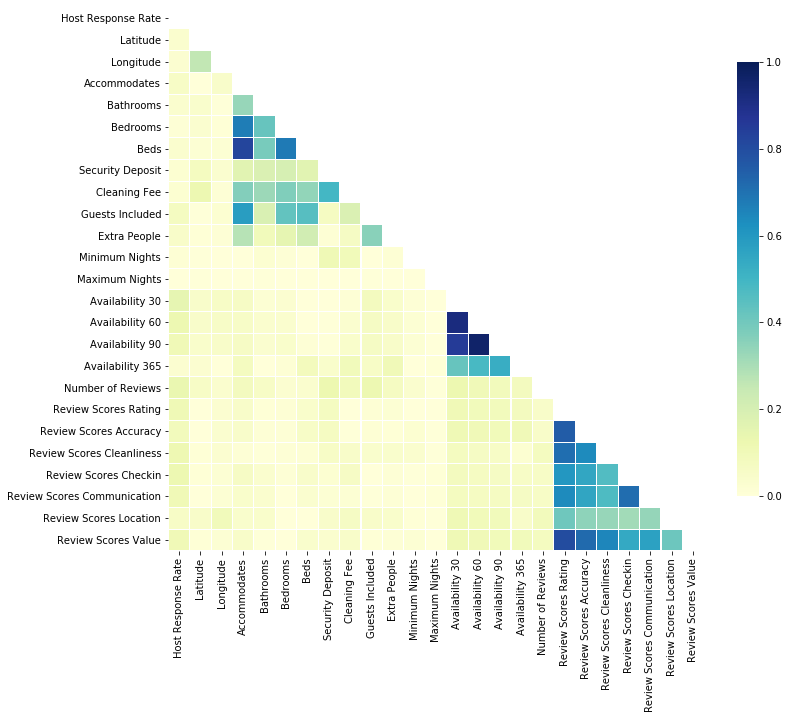

In [46]:
# Para tener una visión mas intuitiva es mejor dibujar la matriz de correlación
# Código obtenido notebook 3.1 Selección de características (análisis exploratorio)
import seaborn as sns

# Compute the correlation matrix
corr = np.abs(df.drop(['Price'], axis=1).corr()) # Eliminamos el precio por ser la variable objetivo

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})


Las zonas azules en la gráfica es donde se muestra que hay correlación entre variables. Hay tres zonas diferenciadas:

- Correlación clara entre beds y accommodates (0.823501). Es una relación lógica porque es el número de personas que pueden entrar a la vivienda y el número de camas disponibles. Eliminaremos accommodates (en módulos anteriores se vio la misma relación).
- Tenemos también correlación entre las variables Availability. Nos quedaremos con Availability 365.
- Asimismo hay correlación entre las variables Review, lo cual también tiene su lógica ya que son características de la vivienda y muchas veces están relaciondas, ya que las evalúa la misma persona. En pro de reducir la dimensionalidad, lo ideal es eliminarlas. Lo normal en estos casos sería hacer una media entre estas características, pero hay una variable, Review Score Value, que parece ser una valoración general (media) que realiza el inquilino acerca de la vivienda. Por tanto, consideraremos esta variable de mayor fiabilidad que un cálculo medio obtenido matemáticamente.

En definitiva, debemos eliminar las siguientes columnas por estar correlacionadas:

'Accommodates', 'Availability 30', 'Availability 60', 'Availability 90', 'Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Checkin', 'Review Scores Communication' y 'Review Scores Location'

In [47]:
df.drop(get_correlated_columns(), axis=1, inplace=True)
df.shape

(10569, 27)

Para terminar este epígrafe, podemos hacer una representación (scatter_plot) de todas las variables frente al resto, para tener una idea de cómo se relacionan las variables del problema. (Notebook 3.1 Selección de características (análisis exploratorio))

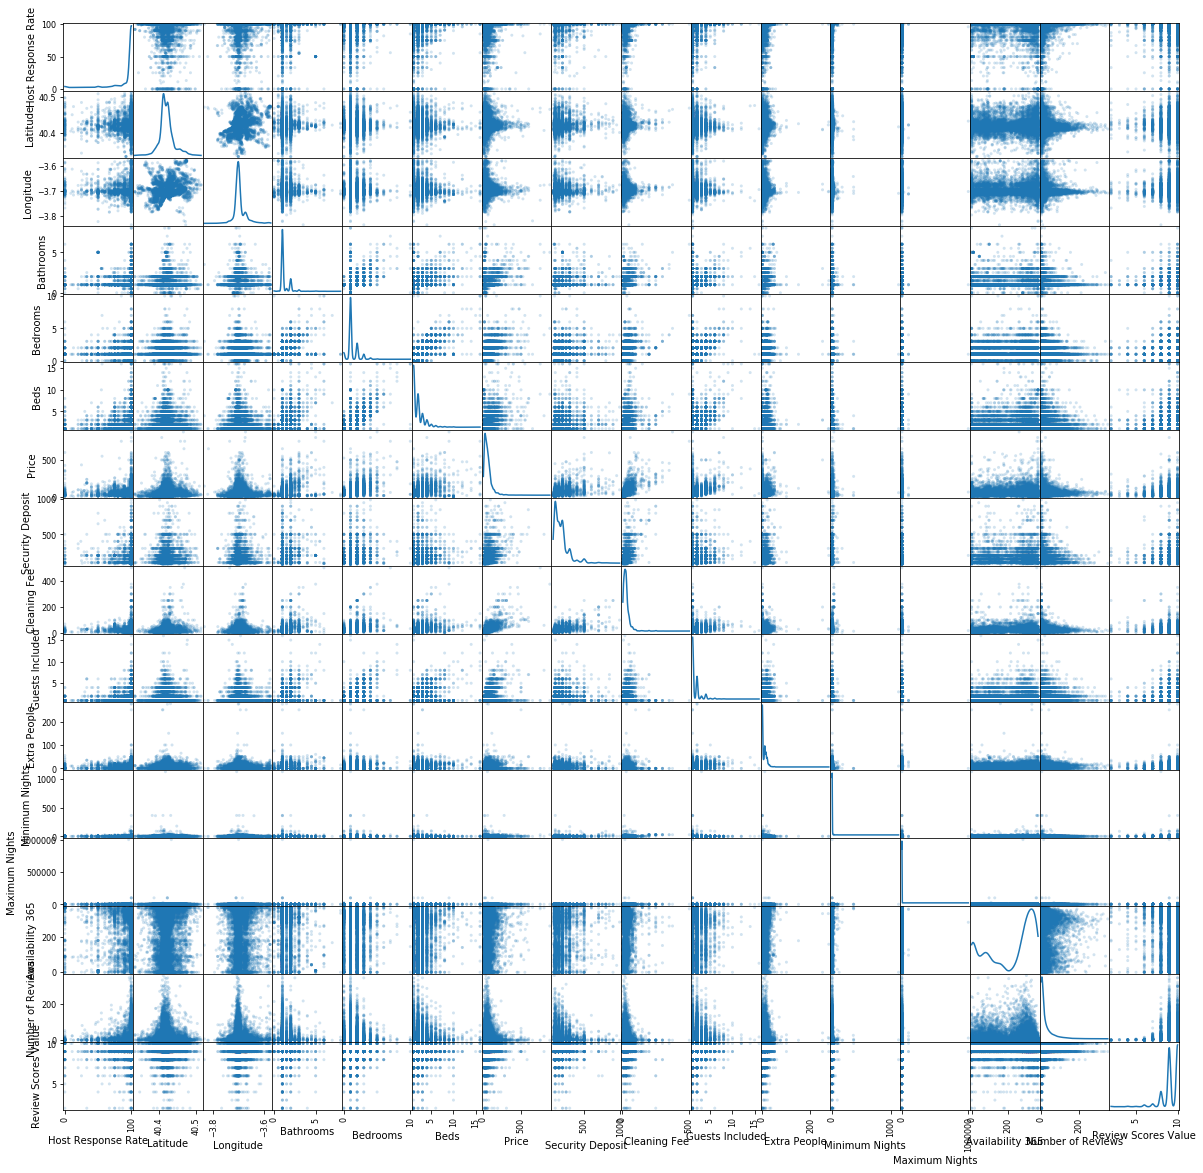

In [48]:
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(20, 20), diagonal = 'kde')
plt.show()

## 3.5 Análisis de outliers, valores 0 y valores nulos
En este epígrafe comprobaremos si hay algún outlier, principalmente, en la variable objetivo. También controlaremos los valores nulos, y 0 en las columnas numéricas.

In [49]:
# Para facilitar el análisis, es conveniente que la variable objetivo sea la primera o la última columna de nuestro dataset. 
# En nuestro caso, vamos a situarla en la primera columna.
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('Price')))
df = df[cols]

In [50]:
# Hacemos un describe del dataset
df.describe().T

count        mean          std        min         25%  \
Price                10561.0   66.183032    56.160570   9.000000   31.000000   
Host Response Rate    9256.0   94.816984    15.282034   0.000000  100.000000   
Latitude             10569.0   40.420437     0.019804  40.332908   40.410092   
Longitude            10569.0   -3.697122     0.023265  -3.835498   -3.707764   
Bathrooms            10529.0    1.256815     0.608137   0.000000    1.000000   
Bedrooms             10551.0    1.294948     0.833204   0.000000    1.000000   
Beds                 10532.0    1.992689     1.529703   1.000000    1.000000   
Security Deposit      4549.0  183.864586   110.595924  70.000000  100.000000   
Cleaning Fee          6284.0   30.024029    27.094512   5.000000   15.000000   
Guests Included      10569.0    1.569117     1.072052   1.000000    1.000000   
Extra People         10569.0    7.421516    10.616336   0.000000    0.000000   
Minimum Nights       10569.0    3.091778    14.130324   1.000000    1.000000   
Maximum Nights       10569.0  976.606301  9927.788832   1.000000  365.000000   
Availability 365     10569.0  205.676601   127.088938   0.000000   83.000000   
Number of Reviews    10569.0   23.168796    38.363573   0.000000    1.000000   
Review Scores Value   8259.0    9.207894     0.965376   2.000000    9.000000   

                             50%          75%             max  
Price                  53.000000    80.000000      875.000000  
Host Response Rate    100.000000   100.000000      100.000000  
Latitude               40.418471    40.427683       40.514247  
Longitude              -3.701568    -3.693876       -3.575142  
Bathrooms               1.000000     1.000000        8.000000  
Bedrooms                1.000000     2.000000       10.000000  
Beds                    1.000000     2.000000       16.000000  
Security Deposit      150.000000   200.000000      990.000000  
Cleaning Fee           25.000000    35.000000      500.000000  
Guests Included         1.000000     2.000000       16.000000  
Extra People            0.000000    14.000000      276.000000  
Minimum Nights          2.000000     3.000000     1125.000000  
Maximum Nights       1125.000000  1125.000000  1000000.000000  
Availability 365      248.000000   320.000000      365.000000  
Number of Reviews       7.000000    28.000000      356.000000  
Review Scores Value     9.000000    10.000000       10.000000

### 3.5.1 Outliers

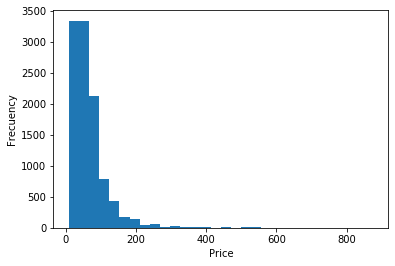

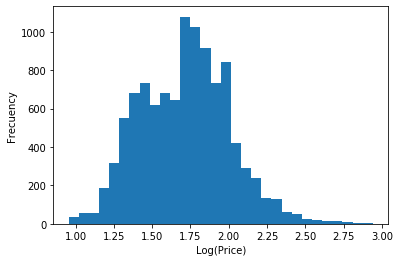

In [51]:
# Llama la atención en Price que siendo la media 66,18 haya un máximo de 875. Vamos a reliazar un histograma. 
# Notebook 3.3 Selección de características (wrapper y embedded)
plt.hist(df['Price'], bins=30)
plt.xlabel('Price')
plt.ylabel('Frecuency')
plt.show()

plt.hist(np.log10(df['Price']), bins=30)
plt.xlabel('Log(Price)')
plt.ylabel('Frecuency')
plt.show()


In [52]:
# Por las gráficas, vemos que los valores outlier se presentan por encima de 200. Estos valores pueden corresponder a
# viviendas similares a hoteles o viviendas de lujo. Vamos a poner el filtro en 330
len(df[df['Price'] > 300])

85

In [53]:
# La variable Price es nuestro objetivo. Debemos tener en cuenta sus valores nulo.
len(df[df['Price'].isnull()])

8

In [54]:
# Normalmente, los valores nulo numéricos se suelen rellenan con el valor medio. En el caso de 
# de la variable objetivo, dado que tenemos pocas filas con nulo, vamos a borrarlas para no influir en los cálculos
# de predicción.
# Finalmente, en el caso de la variable Price borraremos todas las filas con nulos y con un valor superior a 300.
df = df[(df['Price'] <= 300)]

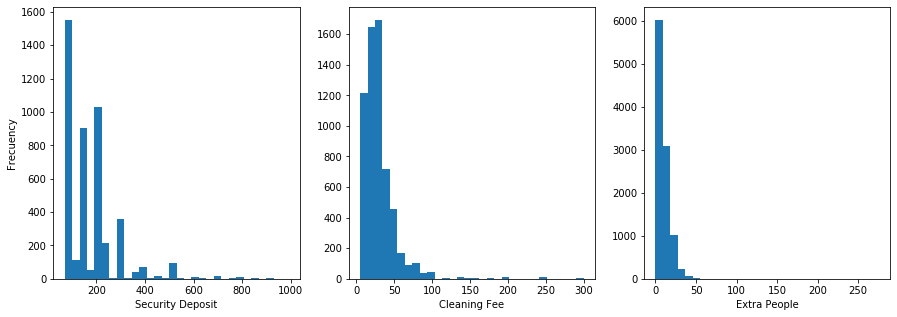

In [55]:
plt.figure(figsize=(15, 5))
# Revisamos los datos de security deposit y cleaning fee

plt.subplot(1,3,1)
plt.hist(df['Security Deposit'], bins=30)
plt.xlabel('Security Deposit')
plt.ylabel('Frecuency')

plt.subplot(1,3,2)
plt.hist(df['Cleaning Fee'], bins=30)
plt.xlabel('Cleaning Fee')

plt.subplot(1,3,3)
plt.hist(df['Extra People'], bins=30)
plt.xlabel('Extra People')

plt.show()


<div class = "alert alert-success">
En entregas de otros módulos del Bootcamp se han analizado relaciones entre security deposit, cleaning fee y price, creando, por ejemplo, una nueva caracterítisca sumando los tres valores, lo cual, aunque en sí mismo no tiene sentido porque el precio es un valor diario, el depósito es una único que al final se devuelve y la tasa de limpieza no queda claro cuál es su frecuencia, puede servir de referencia. La tasa de limpieza influye en la predicción del precio. El depósito en teoría debería influir menos porque es un pago inicial que al final del alquiler se devuelve. Únicamente influirá si es muy alto.
    
TODO: realizar un estudio más exhaustivo de cleaning fee
    
</div>


In [56]:
print(f"Filas con más de 650 en Security Deposit {len(df[df['Security Deposit'] > 650])}")
print(f"Filas con más de 150 en Cleaning Fee {len(df[df['Cleaning Fee'] > 150])}")
print(f"Filas con más de 50 en Extra People {len(df[df['Extra People'] > 50])}")

Filas con más de 650 en Security Deposit 43
Filas con más de 150 en Cleaning Fee 36
Filas con más de 50 en Extra People 16


In [57]:
# Como son relativamente pocos registros, procedemos a borrarlos. Aunque un depósito de 650 y más de 50 personas extras 
# sigue siendo umbrales altos, dejamos estos valores como filtros. Un depósito mayor de 650 puede ser correcto, aunque es un
# tipo de vivienda que no se corresponde con lo que es usual en AirBnB. Lo mismo podemos decir de Cleaning Fee. Más de 50 
# personas extra no tiene sentido, y debe ser algún error.
df = df[(df['Security Deposit'] <= 650) | (df['Security Deposit'].isnull())]
df = df[(df['Cleaning Fee'] <= 150) | (df['Cleaning Fee'].isnull())]
df = df[(df['Extra People'] <= 50) | (df['Extra People'].isnull())]

In [58]:
# Volvemos a realizar un describe del dataset para comprobar si se siguen manteniendo valores outlier
df.describe().T

count        mean           std        min         25%  \
Price                10391.0   62.400154     42.459123   9.000000   30.000000   
Host Response Rate    9105.0   94.836793     15.132780   0.000000  100.000000   
Latitude             10391.0   40.420351      0.019865  40.332908   40.409997   
Longitude            10391.0   -3.697118      0.023345  -3.835498   -3.707795   
Bathrooms            10352.0    1.241016      0.579257   0.000000    1.000000   
Bedrooms             10373.0    1.273884      0.794001   0.000000    1.000000   
Beds                 10355.0    1.956543      1.454029   1.000000    1.000000   
Security Deposit      4456.0  175.993716     90.556337  70.000000  100.000000   
Cleaning Fee          6153.0   27.808386     18.090974   5.000000   15.000000   
Guests Included      10391.0    1.560293      1.037505   1.000000    1.000000   
Extra People         10391.0    7.241266      8.885130   0.000000    0.000000   
Minimum Nights       10391.0    2.974305     14.109029   1.000000    1.000000   
Maximum Nights       10391.0  977.163603  10012.339640   1.000000  365.000000   
Availability 365     10391.0  205.291983    127.113967   0.000000   83.000000   
Number of Reviews    10391.0   23.437398     38.582019   0.000000    1.000000   
Review Scores Value   8177.0    9.209123      0.961744   2.000000    9.000000   

                             50%          75%             max  
Price                  51.000000    80.000000      300.000000  
Host Response Rate    100.000000   100.000000      100.000000  
Latitude               40.418263    40.427610       40.514247  
Longitude              -3.701621    -3.693965       -3.575142  
Bathrooms               1.000000     1.000000        8.000000  
Bedrooms                1.000000     1.000000       10.000000  
Beds                    1.000000     2.000000       16.000000  
Security Deposit      150.000000   200.000000      650.000000  
Cleaning Fee           25.000000    35.000000      150.000000  
Guests Included         1.000000     2.000000       16.000000  
Extra People            5.000000    14.000000       50.000000  
Minimum Nights          2.000000     3.000000     1125.000000  
Maximum Nights       1125.000000  1125.000000  1000000.000000  
Availability 365      247.000000   320.000000      365.000000  
Number of Reviews       8.000000    28.000000      356.000000  
Review Scores Value     9.000000    10.000000       10.000000

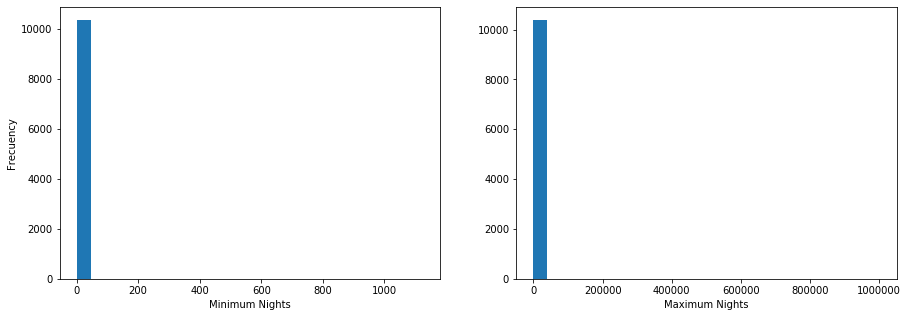

In [59]:
# Resulta llamativo el valor máximo de Minimum y Maximum Nights 
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(df['Minimum Nights'], bins=25)
plt.xlabel('Minimum Nights')
plt.ylabel('Frecuency')

plt.subplot(1,2,2)
plt.hist(df['Maximum Nights'], bins=25)
plt.xlabel('Maximum Nights')

plt.show()


In [60]:
print(f"Filas con más de 365 en Minimum Nights {len(df[df['Minimum Nights'] > 365])}")
print(f"Filas con más de 1125 en Maximum Nights {len(df[df['Maximum Nights'] > 1125])}")

Filas con más de 365 en Minimum Nights 1
Filas con más de 1125 en Maximum Nights 56


In [61]:
# Son relativamente pocos registros y como no desvirtúan el dataset, procedemos a borrarlos.
df = df[(df['Minimum Nights'] <= 365) | (df['Minimum Nights'].isnull())]
df = df[(df['Maximum Nights'] <= 1125) | (df['Maximum Nights'].isnull())]

### 3.5.2 Valores cero

Revisando la tabla obtenida tras ejecutar un describe, vemos que hay columnas con una valor mínimo 0. Las más llamativas son Bathrooms y Bedrooms

In [62]:
print(f"Filas sin ningún baño {len(df[df['Bathrooms'] == 0])}")
print(f"Filas sin ninguna habitación {len(df[df['Bedrooms'] == 0])}")


Filas sin ningún baño 51
Filas sin ninguna habitación 744


Vemos que hay 744 viviendas sin habitaciones. Son muchas y no parece un error. Consideramos que son viviendas de tipo estudio. 

Asimismo vemos que hay 51 viviendas sin baño. Puede considerarse que es un error, o puede considerarse que son viviendas de tipo pensión o similar que tienen baño compartido. Se puede considerar correcto tanto eliminar las filas con baños cero, como no eliminarlas (esta es la conclusión a la que se llegó en anteriores módulos). En este caso vamos a decidir no borrar las filas. En posteriores estudios se podrían borrar.

### 3.5.3 Valores nulos

In [63]:
df.describe().T

count        mean         std        min         25%  \
Price                10334.0   62.365493   42.500320   9.000000   30.000000   
Host Response Rate    9051.0   94.811402   15.172879   0.000000  100.000000   
Latitude             10334.0   40.420359    0.019898  40.332908   40.409991   
Longitude            10334.0   -3.697095    0.023392  -3.835498   -3.707780   
Bathrooms            10296.0    1.240919    0.579280   0.000000    1.000000   
Bedrooms             10316.0    1.272199    0.790005   0.000000    1.000000   
Beds                 10298.0    1.950767    1.444249   1.000000    1.000000   
Security Deposit      4426.0  176.105739   90.709710  70.000000  100.000000   
Cleaning Fee          6104.0   27.822412   18.138685   5.000000   15.000000   
Guests Included      10334.0    1.559125    1.037727   1.000000    1.000000   
Extra People         10334.0    7.224502    8.880243   0.000000    0.000000   
Minimum Nights       10334.0    2.858138    8.806412   1.000000    1.000000   
Maximum Nights       10334.0  826.969808  472.284082   1.000000  360.000000   
Availability 365     10334.0  205.121153  127.152594   0.000000   83.000000   
Number of Reviews    10334.0   23.383104   38.545189   0.000000    1.000000   
Review Scores Value   8127.0    9.209671    0.962675   2.000000    9.000000   

                             50%          75%          max  
Price                  50.000000    80.000000   300.000000  
Host Response Rate    100.000000   100.000000   100.000000  
Latitude               40.418256    40.427619    40.514247  
Longitude              -3.701617    -3.693939    -3.575142  
Bathrooms               1.000000     1.000000     8.000000  
Bedrooms                1.000000     1.000000    10.000000  
Beds                    1.000000     2.000000    16.000000  
Security Deposit      150.000000   200.000000   650.000000  
Cleaning Fee           25.000000    35.000000   150.000000  
Guests Included         1.000000     2.000000    16.000000  
Extra People            0.000000    14.000000    50.000000  
Minimum Nights          2.000000     3.000000   365.000000  
Maximum Nights       1125.000000  1125.000000  1125.000000  
Availability 365      247.000000   320.000000   365.000000  
Number of Reviews       8.000000    28.000000   356.000000  
Review Scores Value     9.000000    10.000000    10.000000

En tabla anterior vemos que hay algunas columnas que tienen menos valores en la columna *count* que en número de filas que tiene el dataframe. Esto se debe a que hay valores nulos que deben ser cumplimentados. Normalmente, los valores nulos numéricos se rellenan con la media y los nulos categóricos con la moda.

En nuestro caso, vemos que hay tres columnas que si tienen valor nulo, lo correcto es rellenarlos con 0. Si no se ha indicado nada en 'Security Deposit', 'Cleaning Fee' o en 'Host Response Rate', lo lógico es pensar que no se cobra nada por el depósito de seguridad y la tasa de limpieza o que el dueño no ha realizado ninguna respuesta.

In [64]:
fillna_with_zero(df)
df.describe().T

count        mean         std        min         25%  \
Price                10334.0   62.365493   42.500320   9.000000   30.000000   
Host Response Rate   10334.0   83.040255   34.339554   0.000000   90.000000   
Latitude             10334.0   40.420359    0.019898  40.332908   40.409991   
Longitude            10334.0   -3.697095    0.023392  -3.835498   -3.707780   
Bathrooms            10296.0    1.240919    0.579280   0.000000    1.000000   
Bedrooms             10316.0    1.272199    0.790005   0.000000    1.000000   
Beds                 10298.0    1.950767    1.444249   1.000000    1.000000   
Security Deposit     10334.0   75.425198  105.443103   0.000000    0.000000   
Cleaning Fee         10334.0   16.433907   19.532042   0.000000    0.000000   
Guests Included      10334.0    1.559125    1.037727   1.000000    1.000000   
Extra People         10334.0    7.224502    8.880243   0.000000    0.000000   
Minimum Nights       10334.0    2.858138    8.806412   1.000000    1.000000   
Maximum Nights       10334.0  826.969808  472.284082   1.000000  360.000000   
Availability 365     10334.0  205.121153  127.152594   0.000000   83.000000   
Number of Reviews    10334.0   23.383104   38.545189   0.000000    1.000000   
Review Scores Value   8127.0    9.209671    0.962675   2.000000    9.000000   

                             50%          75%          max  
Price                  50.000000    80.000000   300.000000  
Host Response Rate    100.000000   100.000000   100.000000  
Latitude               40.418256    40.427619    40.514247  
Longitude              -3.701617    -3.693939    -3.575142  
Bathrooms               1.000000     1.000000     8.000000  
Bedrooms                1.000000     1.000000    10.000000  
Beds                    1.000000     2.000000    16.000000  
Security Deposit        0.000000   150.000000   650.000000  
Cleaning Fee           10.000000    30.000000   150.000000  
Guests Included         1.000000     2.000000    16.000000  
Extra People            0.000000    14.000000    50.000000  
Minimum Nights          2.000000     3.000000   365.000000  
Maximum Nights       1125.000000  1125.000000  1125.000000  
Availability 365      247.000000   320.000000   365.000000  
Number of Reviews       8.000000    28.000000   356.000000  
Review Scores Value     9.000000    10.000000    10.000000

In [65]:
# El resto de columnas las rellenamos con la media. En teoría, deberíamos rendondear las medias obtenidas porque
# las variables siguientes solo admiten números enteros (hay una o dos camas, pero no cama y media);
# decidimos dejar los valores con decimales, porque favoceren las predicción del precio y, en caso de necesidad,
# es más fácil localizar las filas en las que estos datos se han rellenado automáticamente.

# Guardamos los valores medios en variables para poder luegar asignar estos valores al dataset de test.

mean_Bathrooms = df['Bathrooms'].mean()
mean_Bedrooms = df['Bedrooms'].mean()
mean_Beds = df['Beds'].mean()
mean_Review_Scores_Value = df['Review Scores Value'].mean()
print (f'Media de baños {mean_Bathrooms}')
print (f'Media de habitaciones {mean_Bedrooms}')
print (f'Media de camas {mean_Beds}')
print (f'Media de puntaciones {mean_Review_Scores_Value}')

df = fillna_with_means(df)
df.describe().T

Media de baños 1.2409188034188035
Media de habitaciones 1.2721985265606823
Media de camas 1.9507671392503398
Media de puntaciones 9.20967146548542


count        mean         std        min         25%  \
Price                10334.0   62.365493   42.500320   9.000000   30.000000   
Host Response Rate   10334.0   83.040255   34.339554   0.000000   90.000000   
Latitude             10334.0   40.420359    0.019898  40.332908   40.409991   
Longitude            10334.0   -3.697095    0.023392  -3.835498   -3.707780   
Bathrooms            10334.0    1.240919    0.578214   0.000000    1.000000   
Bedrooms             10334.0    1.272199    0.789316   0.000000    1.000000   
Beds                 10334.0    1.950767    1.441731   1.000000    1.000000   
Security Deposit     10334.0   75.425198  105.443103   0.000000    0.000000   
Cleaning Fee         10334.0   16.433907   19.532042   0.000000    0.000000   
Guests Included      10334.0    1.559125    1.037727   1.000000    1.000000   
Extra People         10334.0    7.224502    8.880243   0.000000    0.000000   
Minimum Nights       10334.0    2.858138    8.806412   1.000000    1.000000   
Maximum Nights       10334.0  826.969808  472.284082   1.000000  360.000000   
Availability 365     10334.0  205.121153  127.152594   0.000000   83.000000   
Number of Reviews    10334.0   23.383104   38.545189   0.000000    1.000000   
Review Scores Value  10334.0    9.209671    0.853700   2.000000    9.000000   

                             50%          75%          max  
Price                  50.000000    80.000000   300.000000  
Host Response Rate    100.000000   100.000000   100.000000  
Latitude               40.418256    40.427619    40.514247  
Longitude              -3.701617    -3.693939    -3.575142  
Bathrooms               1.000000     1.000000     8.000000  
Bedrooms                1.000000     1.000000    10.000000  
Beds                    1.000000     2.000000    16.000000  
Security Deposit        0.000000   150.000000   650.000000  
Cleaning Fee           10.000000    30.000000   150.000000  
Guests Included         1.000000     2.000000    16.000000  
Extra People            0.000000    14.000000    50.000000  
Minimum Nights          2.000000     3.000000   365.000000  
Maximum Nights       1125.000000  1125.000000  1125.000000  
Availability 365      247.000000   320.000000   365.000000  
Number of Reviews       8.000000    28.000000   356.000000  
Review Scores Value     9.209671    10.000000    10.000000

## 3.6 Variables categóricas

En este apartado vamos a analizar las variables no numéricas

In [66]:
list(df.select_dtypes(include=['object']).columns)

['Experiences Offered',
 'Host Since',
 'Host Response Time',
 'Host Verifications',
 'Neighbourhood Cleansed',
 'Property Type',
 'Room Type',
 'Bed Type',
 'Amenities',
 'Cancellation Policy',
 'Features']

In [67]:
df_objects = df[list(df.select_dtypes(include=['object']).columns)]
df_objects.head(10)

Experiences Offered  Host Since  Host Response Time  \
0                 none  2015-04-13  within a few hours   
1                 none  2016-07-22      within an hour   
2                 none  2016-07-17      within an hour   
3                 none  2014-05-08  within a few hours   
4                 none  2012-02-06      within an hour   
5                 none  2014-05-16      within an hour   
6                 none  2012-03-25  within a few hours   
7                 none  2014-05-08  within a few hours   
10                none  2016-07-09      within an hour   
11                none  2011-03-18      within an hour   

                                   Host Verifications Neighbourhood Cleansed  \
0                      email,phone,reviews,work_email              Jerónimos   
1   email,phone,reviews,jumio,offline_government_i...                    Sol   
2   email,phone,facebook,google,reviews,jumio,gove...           Vista Alegre   
3                      email,phone,reviews,work_email            Embajadores   
4                           email,phone,reviews,jumio             Gaztambide   
5                           email,phone,reviews,jumio            Embajadores   
6                                 email,phone,reviews                Palacio   
7                      email,phone,reviews,work_email                    Sol   
10  email,phone,reviews,jumio,offline_government_i...            Embajadores   
11                                email,phone,reviews       Fuente del Berro   

   Property Type        Room Type  Bed Type  \
0      Apartment  Entire home/apt  Real Bed   
1      Apartment  Entire home/apt  Real Bed   
2      Apartment      Shared room  Real Bed   
3      Apartment     Private room  Real Bed   
4      Apartment     Private room  Real Bed   
5      Apartment     Private room  Real Bed   
6      Apartment  Entire home/apt  Real Bed   
7      Apartment     Private room  Real Bed   
10     Apartment     Private room  Real Bed   
11     Apartment  Entire home/apt  Real Bed   

                                            Amenities Cancellation Policy  \
0   TV,Internet,Wireless Internet,Air conditioning...            moderate   
1   TV,Internet,Wireless Internet,Air conditioning...            flexible   
2   Internet,Wireless Internet,Wheelchair accessib...            moderate   
3   Wireless Internet,Kitchen,Smoking allowed,Heat...              strict   
4   TV,Cable TV,Internet,Wireless Internet,Air con...              strict   
5   TV,Internet,Wireless Internet,Wheelchair acces...              strict   
6   TV,Cable TV,Internet,Wireless Internet,Air con...            flexible   
7   Wireless Internet,Kitchen,Smoking allowed,Elev...              strict   
10  TV,Wireless Internet,Kitchen,Heating,Family/ki...            moderate   
11  TV,Wireless Internet,Air conditioning,Kitchen,...            flexible   

                                             Features  
0   Host Has Profile Pic,Is Location Exact,Require...  
1   Host Has Profile Pic,Host Identity Verified,Re...  
2   Host Has Profile Pic,Host Identity Verified,Is...  
3               Host Has Profile Pic,Requires License  
4   Host Has Profile Pic,Host Identity Verified,Is...  
5   Host Is Superhost,Host Has Profile Pic,Host Id...  
6   Host Is Superhost,Host Has Profile Pic,Require...  
7   Host Has Profile Pic,Is Location Exact,Require...  
10  Host Has Profile Pic,Host Identity Verified,Is...  
11  Host Has Profile Pic,Is Location Exact,Require...

Vamos a realizar una serie de comprobaciones similares a las realizadas con las variables numéricas

### 3.6.1 Valores nulo

Igual que antes, comprobaremos los valores nulos de cada variable de tipo object

In [68]:
len(df_objects) - df_objects.count()

Experiences Offered          0
Host Since                   3
Host Response Time        1283
Host Verifications           3
Neighbourhood Cleansed       0
Property Type                0
Room Type                    0
Bed Type                     0
Amenities                   85
Cancellation Policy          0
Features                     0
dtype: int64

In [69]:
# Observamos que 'Host Since' tiene solo tres fila nulas, por lo que procedemos a borrarlas
df = dropna_in_host_since(df)

In [70]:
# Host verifications y Amenities son columnas que tienen listas de valores separadas por comas. Lo lógico es pensar que 
# si un valor es nulo, lo equivalente es poner cadena vacía, es decir, lista vacía de valores. También trataremos estas
# columnas más adelante en la sección de Ponderación.
df = fillna_with_empty_string(df)

In [71]:
# Por último, vemos que Host Reponse Time tiene bastantes nulos. En este caso, lo correcto es rellenar con la moda
mode_Host_Response_Time = df["Host Response Time"].mode()[0]
df = fillna_Host_Response_Time_with_its_mode(df)

In [72]:
# Comprobamos de nuevo si hay nulos
df_objects = df[list(df.select_dtypes(include=['object']).columns)]
len(df_objects) - df_objects.count()

Experiences Offered       0
Host Since                0
Host Response Time        0
Host Verifications        0
Neighbourhood Cleansed    0
Property Type             0
Room Type                 0
Bed Type                  0
Amenities                 0
Cancellation Policy       0
Features                  0
dtype: int64

### 3.6.2 Valores vacíos

En este apartado se tratarán valores de cadena que se consideren valor vacíos equivalentes a nulo. En este sentido, la columna que presenta un valor de este estilo es *Experiences Offered*: none

In [73]:
df["Experiences Offered"].value_counts()

none    10331
Name: Experiences Offered, dtype: int64

In [74]:
# Vemos que todos sus valores son none, por tanto, procedemos a borrar esta columna
df = df.drop(get_empty_columns(), axis=1)

### 3.6.3 Conversión de variables de tipo cadena a tipo numérico

#### 3.6.3.1 Encoding
En este apartado vamos a estudiar si es posible y tiene sentido sustituir literales/categorías por números, esto es, realizar operaciones de codificación (encoding) de variables cuyos valores son listas acotadas en forma texto.

Las columnas sobre las que vamos a relizar el estudio son:

'Host Response Time', 'Neighbourhood Cleansed', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy'

Podemos hacer un preanálisis de cómo estas variables están relacionadas con el precio mediante gráficos boxplot
 

**host respose time vs price**

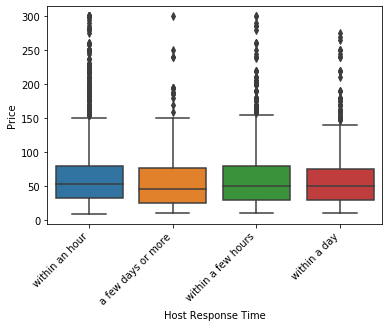

In [75]:
sort_price = df.groupby('Host Response Time')['Price'].mean().sort_values(ascending=False).index
sns.boxplot(y='Price', x='Host Response Time', data=df, order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

Vemos que la media del precio según el tiempo de respuesta del dueños es muy similar en todos los casos. No parece que influya.

**'Neighbourhood Cleansed vs price**

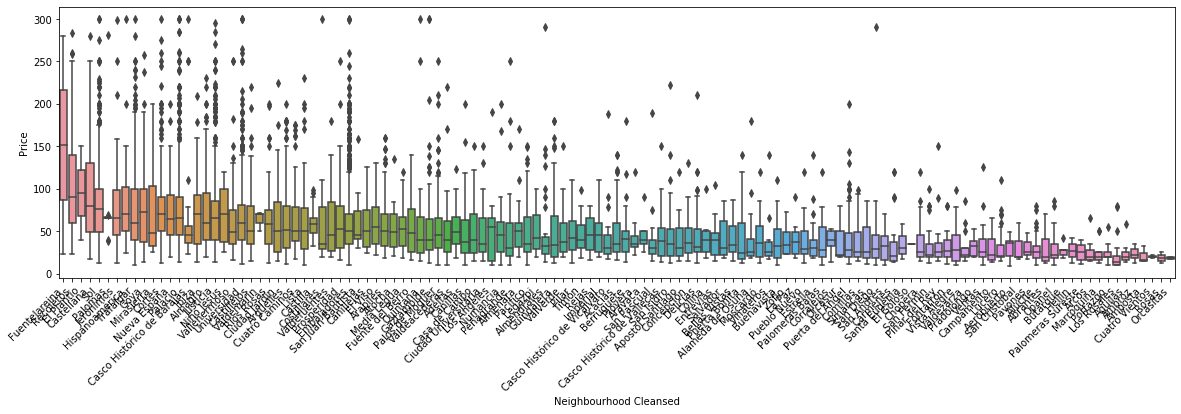

In [76]:
plt.figure(figsize=(20, 5))
sort_price = df.groupby('Neighbourhood Cleansed')['Price'].mean().sort_values(ascending=False).index
sns.boxplot(y='Price', x='Neighbourhood Cleansed', data=df, order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

Vemos que hay barrios cuya media de precio es claramente superior al resto. El barrio influye en el precio.

**property type**

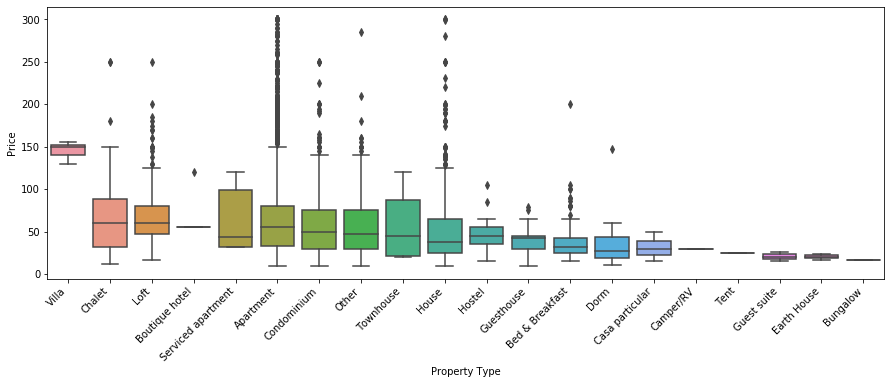

In [77]:
plt.figure(figsize=(15, 5))
sort_price = df.groupby('Property Type')['Price'].mean().sort_values(ascending=False).index
sns.boxplot(y='Price', x='Property Type', data=df, order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

El tipo de propiedad tiene influencia en el precio, ya que hay variación en la medias de los precios en algún tipo de propiedad (Villa)

**room type**

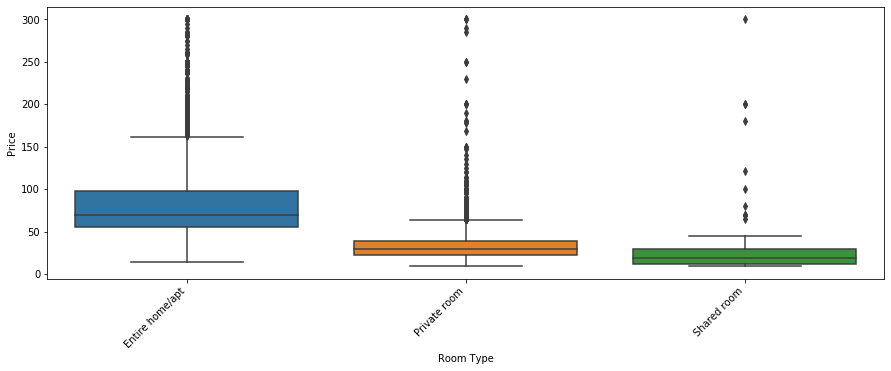

In [78]:
plt.figure(figsize=(15, 5))
sort_price = df.groupby('Room Type')['Price'].mean().sort_values(ascending=False).index
sns.boxplot(y='Price', x='Room Type', data=df, order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

Las viviendas/apartamentos completos, sin el dueño en casa, son los mayor precio. Podemos analizar también la cantidad de viviendas que se ofrecen de cada tipo, mediante un histograma de barras en pila (stacked)


Text(0.5, 0, 'Price')

<Figure size 1080x360 with 0 Axes>

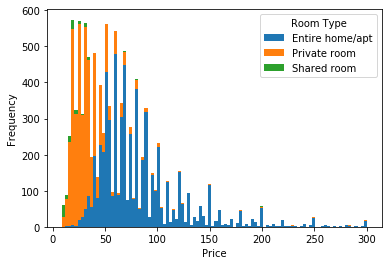

In [79]:
plt.figure(figsize=(15, 5))
df.pivot(columns = 'Room Type', values = 'Price').plot.hist(stacked = True, bins=100)
plt.xlabel('Price')

Se observa que lo que más se ofrece son habitaciones privadas en la parte de precios menores, pero lo que más abarca, e incluso empezando en precios relativamente baratos, son las viviendas/apartamentos completos sin dueño.

**Bed type**

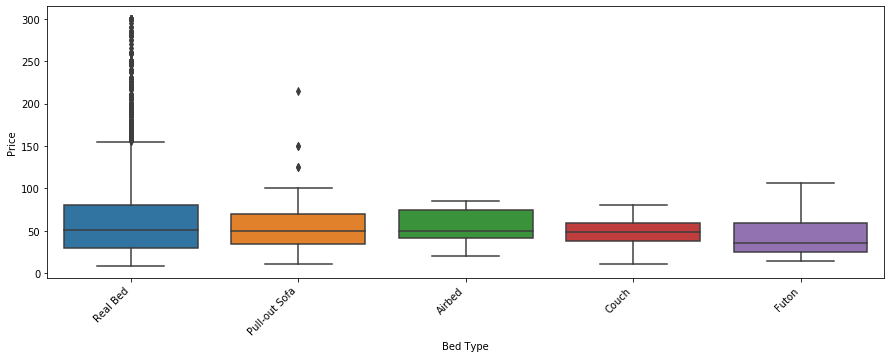

In [80]:
plt.figure(figsize=(15, 5))
sort_price = df.groupby('Bed Type')['Price'].mean().sort_values(ascending=False).index
sns.boxplot(y='Price', x='Bed Type', data=df, order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

El precio medio de la cama es más o menos el mismo para todos los tipos, aunque hay más variedad de precios en "Real Bed"

**Cancellation Policy**

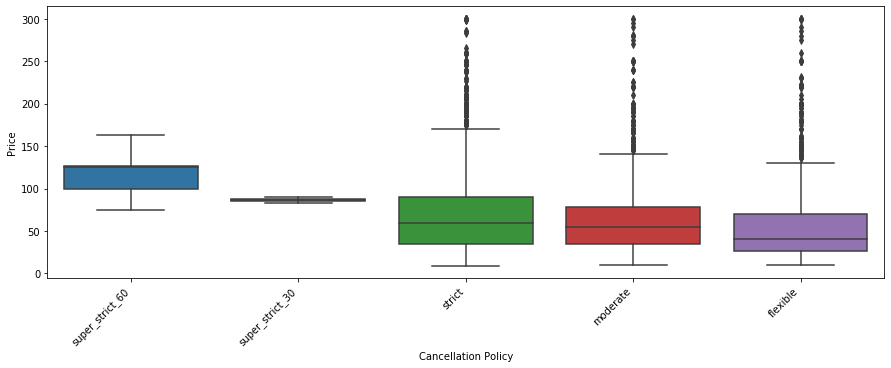

In [81]:
plt.figure(figsize=(15, 5))
sort_price = df.groupby('Cancellation Policy')['Price'].mean().sort_values(ascending=False).index
sns.boxplot(y='Price', x='Cancellation Policy', data=df, order=sort_price)
ax = plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show();

Los precios son diferentes en las distintas políticas de cancelación.

Realizado este preanálisis de estas variables con los precios medios, se decide sustutir cada valor (categoría) por la media del precio de dicho valor en cada columna analizada. Se va a utilizar la técnica de Mean Encoding explicada [aquí](https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02)


In [82]:
# Calculamos precios medios por cada categoría dentro de cada variable categórica
# Almacenamos los precios medios para su uso posterior
for var in get_categorical_variables():
    mean_price_map[var] = df.groupby(var)['Price'].mean()
    
# Asignamos    
df = mean_encoding_to_categorical_variables(df)
# Guardamos el precio medio general por si en test hay variables categóricas que no están en train
# En este tipo de casos es bastante común hacer medias de medias, pero en el nuestro, hemos preferido utilizar el precio medio
# general, porque no hay mucha diferencia.
overall_mean_price = df['Price'].mean()

#### 3.6.3.2 Ponderaciones

En este apartado vamos fijarmos en las columnas de tipos Object (string) que tienen internamente listas de valores separados por comas.

Las columnas que vamos a examinar son

'Amenities', 'Features' y 'Host Verifications'

In [83]:
df.Amenities[:5].values

array(['TV,Internet,Wireless Internet,Air conditioning,Kitchen,Doorman,Elevator in building,Buzzer/wireless intercom,Heating,Family/kid friendly,Washer,Essentials,Hangers',
       'TV,Internet,Wireless Internet,Air conditioning,Kitchen,Elevator in building,Heating,Family/kid friendly,Washer,Smoke detector,Carbon monoxide detector,Essentials,Shampoo,24-hour check-in,Hangers,Hair dryer,Iron,Laptop friendly workspace',
       'Internet,Wireless Internet,Wheelchair accessible,Pool,Kitchen,Free parking on premises,Doorman,Breakfast,Elevator in building,Buzzer/wireless intercom,Heating,Family/kid friendly,Suitable for events,Washer,Smoke detector,First aid kit,Safety card,Fire extinguisher,Essentials,Shampoo,Lock on bedroom door,Hangers,Hair dryer,Iron,Laptop friendly workspace',
       'Wireless Internet,Kitchen,Smoking allowed,Heating,Washer',
       'TV,Cable TV,Internet,Wireless Internet,Air conditioning,Wheelchair accessible,Kitchen,Doorman,Elevator in building,Buzzer/wireless intercom,

In [84]:
df.Features[:5].values

array(['Host Has Profile Pic,Is Location Exact,Requires License',
       'Host Has Profile Pic,Host Identity Verified,Requires License,Instant Bookable',
       'Host Has Profile Pic,Host Identity Verified,Is Location Exact,Requires License,Instant Bookable',
       'Host Has Profile Pic,Requires License',
       'Host Has Profile Pic,Host Identity Verified,Is Location Exact,Requires License'],
      dtype=object)

In [85]:
df['Host Verifications'][:5].values

array(['email,phone,reviews,work_email',
       'email,phone,reviews,jumio,offline_government_id,government_id',
       'email,phone,facebook,google,reviews,jumio,government_id',
       'email,phone,reviews,work_email', 'email,phone,reviews,jumio'],
      dtype=object)

En esta práctica se decide realizar la conversión más usual y simple cuando el contenido son listas: sustituir el contenido por el número de elementos que tiene la lista. Con esta conversión estamos indicando,a priori, que las viviendas que tienen más amenities, características o que el dueño tiene más medios de verificación tienen más influencia sobre el precio, lo cual, aunque parece una deducción lógica, no tiene por qué ser cierta.

<div class = "alert alert-success">
TODO: La solución adaptada es la más sencilla y directa, pero habría sido mejor realizar un estudio de, por ejemplo, Amenities, qué elementos son los que más influyen en el precio y asignarles un valor ponderado. Por ejemplo, una vivienda sin aire acondicionado, podría ser más barata, pero más difícil de alquilar. Parte del código que deberíamos desarrollar lo podemos encontrar en 
    <a href="https://github.com/peternmai/Airbnb_Price_Prediction/blob/master/AirBnB%20Price%20Prediction.ipynb" target="_blank">aquí</a>, en la función getAmenityList
</div>

In [86]:
df=count_elements_in_list(df)

# 4. Generación de características

En esta sección añadiremos nuevas columnas/características a partir de las ya existentes para facilitar la predicción del precio.

Comprobamos si tenemos algún valor nulo en el dataframe (esta vez la comprobación la hacemos de manera distinta a como lo hemos hecho en otras ocasiones anteriormente)

In [87]:
df.isna().sum()

Price                     0
Host Since                0
Host Response Time        0
Host Response Rate        0
Host Verifications        0
Neighbourhood Cleansed    0
Latitude                  0
Longitude                 0
Property Type             0
Room Type                 0
Bathrooms                 0
Bedrooms                  0
Beds                      0
Bed Type                  0
Amenities                 0
Security Deposit          0
Cleaning Fee              0
Guests Included           0
Extra People              0
Minimum Nights            0
Maximum Nights            0
Availability 365          0
Number of Reviews         0
Review Scores Value       0
Cancellation Policy       0
Features                  0
dtype: int64

Como era de esperar, ya no tenemos valores nulos

Ahora comprobaremos, los tipos de cada columna

In [88]:
df.dtypes

Price                     float64
Host Since                 object
Host Response Time        float64
Host Response Rate        float64
Host Verifications          int64
Neighbourhood Cleansed    float64
Latitude                  float64
Longitude                 float64
Property Type             float64
Room Type                 float64
Bathrooms                 float64
Bedrooms                  float64
Beds                      float64
Bed Type                  float64
Amenities                   int64
Security Deposit          float64
Cleaning Fee              float64
Guests Included             int64
Extra People                int64
Minimum Nights              int64
Maximum Nights              int64
Availability 365            int64
Number of Reviews           int64
Review Scores Value       float64
Cancellation Policy       float64
Features                    int64
dtype: object

# 4.1 Conversión de características

Comprobamos que sólo hay una variable, Host Since, de tipo Object. De esta columna solo nos interesa saber cuántos años tiene de antigüedad la vivienda en Airbnb a día de hoy (año 2020). En este apartado vamos a aplicar la conversión realizada en el notebook *9.Casos prácticos*

In [89]:
df = calculate_years(df)

In [90]:
df.describe().T

count        mean         std        min  \
Price                   10331.0   62.368115   42.502265   9.000000   
Host Response Time      10331.0   62.368115    1.597235  58.042834   
Host Response Rate      10331.0   83.064369   34.315365   0.000000   
Host Verifications      10331.0    4.116833    1.290969   1.000000   
Neighbourhood Cleansed  10331.0   62.368115   15.340068  18.500000   
Latitude                10331.0   40.420355    0.019894  40.332908   
Longitude               10331.0   -3.697098    0.023393  -3.835498   
Property Type           10331.0   62.368115    5.992527  17.000000   
Room Type               10331.0   62.368115   24.475190  28.089041   
Bathrooms               10331.0    1.240989    0.578284   0.000000   
Bedrooms                10331.0    1.272278    0.789417   0.000000   
Beds                    10331.0    1.951043    1.441849   1.000000   
Bed Type                10331.0   62.368115    1.537131  43.666667   
Amenities               10331.0   14.262608    4.689637   1.000000   
Security Deposit        10331.0   75.418062  105.430039   0.000000   
Cleaning Fee            10331.0   16.438680   19.532870   0.000000   
Guests Included         10331.0    1.559288    1.037834   1.000000   
Extra People            10331.0    7.226600    8.880679   0.000000   
Minimum Nights          10331.0    2.858097    8.807558   1.000000   
Maximum Nights          10331.0  826.990224  472.267716   1.000000   
Availability 365        10331.0  205.180718  127.122991   0.000000   
Number of Reviews       10331.0   23.389894   38.548725   0.000000   
Review Scores Value     10331.0    9.209671    0.853823   2.000000   
Cancellation Policy     10331.0   62.368115    6.463978  54.523951   
Features                10331.0    3.764302    1.034313   1.000000   
Years                   10331.0    5.694512    1.619517   3.000000   

                               25%          50%          75%          max  
Price                    30.000000    50.000000    80.000000   300.000000  
Host Response Time       62.460938    63.086260    63.086260    63.086260  
Host Response Rate       90.000000   100.000000   100.000000   100.000000  
Host Verifications        3.000000     4.000000     5.000000    10.000000  
Neighbourhood Cleansed   52.719807    61.728571    74.208625   151.500000  
Latitude                 40.409991    40.418255    40.427618    40.514247  
Longitude                -3.707781    -3.701618    -3.693947    -3.575142  
Property Type            64.073259    64.073259    64.073259   145.000000  
Room Type                32.958035    82.606945    82.606945    82.606945  
Bathrooms                 1.000000     1.000000     1.000000     8.000000  
Bedrooms                  1.000000     1.000000     1.000000    10.000000  
Beds                      1.000000     1.000000     2.000000    16.000000  
Bed Type                 62.581312    62.581312    62.581312    62.581312  
Amenities                11.000000    14.000000    17.000000    34.000000  
Security Deposit          0.000000     0.000000   150.000000   650.000000  
Cleaning Fee              0.000000    10.000000    30.000000   150.000000  
Guests Included           1.000000     1.000000     2.000000    16.000000  
Extra People              0.000000     0.000000    14.000000    50.000000  
Minimum Nights            1.000000     2.000000     3.000000   365.000000  
Maximum Nights          360.000000  1125.000000  1125.000000  1125.000000  
Availability 365         83.000000   247.000000   320.000000   365.000000  
Number of Reviews         1.000000     8.000000    28.000000   356.000000  
Review Scores Value       9.000000     9.209671    10.000000    10.000000  
Cancellation Policy      54.523951    61.679590    69.704841   117.800000  
Features                  3.000000     4.000000     4.000000     8.000000  
Years                     4.000000     5.000000     7.000000    11.000000

## 4.2 Combinación de características

En este apartado vamos a combinar distintas características con el fin de comprobar si ayudan a predecir el precio.

**bedrooms y bathrooms**

Vamos a crear una nueva característica con la combinación de ambas columnas para resaltar el hecho de una vivienda de 9 habitaciones pero sólo un baño tiene el mismo peso que una vivienda de 3 habitaciones y 3 baños. Normalmente, cuantas más habitaciones tenga una vivienda, mejor estará valorada, pero debe tener un número de baños acorde.

Así pues, al igual que se hizo en el notebook *3.3 Selección de características (wrapper y embedded)* en la sección *2. Métodos  Embedded*, vamos a crear una nueva variable con la multiplicación de las dos columnas mencionadas

In [91]:
df = create_bed_bath_rooms(df)

**bedrooms**

Asimismo, como es bastante evidente que el número de habitaciones es un factor muy importante a la hora de predecir el precio, vamos a crear una nueva característica que sea el cuadrado de dicha variable, tal y como se hizo en el notebook *3.3 Selección de características (wrapper y embedded)* en la sección *2. Métodos  Embedded*

In [92]:
df = create_bedrooms_squared(df)

## 4.3 Creación de nuevas características utilizando datos externos

En este epígrafe vamos a crear una caracerística totalmente nueva que sume la distancia de la vivienda a todos los puntos turísticos de interés de la Comunidad de Madrid. Se supone que al ser las viviendas de Airbnb con fin turístico, cuanto menor sea la distancia, mayor será el precio. 

En módulos anteriores, en la práctica final, hice algo similar, pero con oficinas de turismo, en lugar de con puntos de interés turístico.

Los puntos turísticos se pueden descargar de <a href="https://datos.madrid.es/egob/catalogo/300030-10037182-puntos-interes-turistico.xml" target="_blank">aquí</a>. El archivo descargado lo hemos llamado es *turismo_v1_es.xml*.

El código siguiente tarda unos 4 minutos en ejecutarse.


In [93]:
import xml.etree.ElementTree as ET
import html
tree = ET.parse('turismo_v1_es.xml')
root = tree.getroot()

# A partir del archivo xml creamos un archivos csv con el nombre del punto turístico, latitud, longitud y código postal
f = open("puntos_turisticos_madrid.csv", "w", encoding="UTF-8")
f.write("name;latitude;longitude;zipcode\n")
for service in root.findall('service'):
    geoData = service.find('geoData')
    zipcode = geoData.find('zipcode').text
    latitude = geoData.find('latitude').text
    longitude = geoData.find('longitude').text
    name = html.unescape(service.find('basicData').find('name').text).strip()
    f.write(f'{name};{latitude};{longitude};{zipcode}\n')
f.close()


In [94]:
# Cargamos el archivo csv recién creado con los puntos turísticos de Madrid en un dataframe de pandas
df_turistico = pd.read_csv('./puntos_turisticos_madrid.csv', sep=';', decimal='.')

# Añadimos una nueva característica al dataframe de Airbnb en la se calcula la distancia media de la vivienda a todos los 
# puntos turísticos de Madrid
df = create_mean_touristic_distance(df, df_turistico)

In [95]:
df.describe().T

count        mean         std        min  \
Price                    10331.0   62.368115   42.502265   9.000000   
Host Response Time       10331.0   62.368115    1.597235  58.042834   
Host Response Rate       10331.0   83.064369   34.315365   0.000000   
Host Verifications       10331.0    4.116833    1.290969   1.000000   
Neighbourhood Cleansed   10331.0   62.368115   15.340068  18.500000   
Latitude                 10331.0   40.420355    0.019894  40.332908   
Longitude                10331.0   -3.697098    0.023393  -3.835498   
Property Type            10331.0   62.368115    5.992527  17.000000   
Room Type                10331.0   62.368115   24.475190  28.089041   
Bathrooms                10331.0    1.240989    0.578284   0.000000   
Bedrooms                 10331.0    1.272278    0.789417   0.000000   
Beds                     10331.0    1.951043    1.441849   1.000000   
Bed Type                 10331.0   62.368115    1.537131  43.666667   
Amenities                10331.0   14.262608    4.689637   1.000000   
Security Deposit         10331.0   75.418062  105.430039   0.000000   
Cleaning Fee             10331.0   16.438680   19.532870   0.000000   
Guests Included          10331.0    1.559288    1.037834   1.000000   
Extra People             10331.0    7.226600    8.880679   0.000000   
Minimum Nights           10331.0    2.858097    8.807558   1.000000   
Maximum Nights           10331.0  826.990224  472.267716   1.000000   
Availability 365         10331.0  205.180718  127.122991   0.000000   
Number of Reviews        10331.0   23.389894   38.548725   0.000000   
Review Scores Value      10331.0    9.209671    0.853823   2.000000   
Cancellation Policy      10331.0   62.368115    6.463978  54.523951   
Features                 10331.0    3.764302    1.034313   1.000000   
Years                    10331.0    5.694512    1.619517   3.000000   
bed_bath_rooms           10331.0    1.748799    2.168313   0.000000   
bedrooms_squared         10331.0    2.241809    3.736396   0.000000   
mean_touristic_distance  10331.0    4.674135    1.564961   3.549033   

                                25%          50%          75%          max  
Price                     30.000000    50.000000    80.000000   300.000000  
Host Response Time        62.460938    63.086260    63.086260    63.086260  
Host Response Rate        90.000000   100.000000   100.000000   100.000000  
Host Verifications         3.000000     4.000000     5.000000    10.000000  
Neighbourhood Cleansed    52.719807    61.728571    74.208625   151.500000  
Latitude                  40.409991    40.418255    40.427618    40.514247  
Longitude                 -3.707781    -3.701618    -3.693947    -3.575142  
Property Type             64.073259    64.073259    64.073259   145.000000  
Room Type                 32.958035    82.606945    82.606945    82.606945  
Bathrooms                  1.000000     1.000000     1.000000     8.000000  
Bedrooms                   1.000000     1.000000     1.000000    10.000000  
Beds                       1.000000     1.000000     2.000000    16.000000  
Bed Type                  62.581312    62.581312    62.581312    62.581312  
Amenities                 11.000000    14.000000    17.000000    34.000000  
Security Deposit           0.000000     0.000000   150.000000   650.000000  
Cleaning Fee               0.000000    10.000000    30.000000   150.000000  
Guests Included            1.000000     1.000000     2.000000    16.000000  
Extra People               0.000000     0.000000    14.000000    50.000000  
Minimum Nights             1.000000     2.000000     3.000000   365.000000  
Maximum Nights           360.000000  1125.000000  1125.000000  1125.000000  
Availability 365          83.000000   247.000000   320.000000   365.000000  
Number of Reviews          1.000000     8.000000    28.000000   356.000000  
Review Scores Value        9.000000     9.209671    10.000000    10.000000  
Cancellation Policy       54.523951    61.679590

# 5 Creación y validación de modelos

El problema al que nos enfrementamos, predecir el precio, es de regresión. Los modelos que vamos a probar son los mejor resultado nos han dado a largo de todo el módulo:

- Lasso Regressor
- Gradient Boosting Regressor
- Random Forest Regressor

## 5.1 Lasso Regressor

Este modelo nos ayuda a seleccionar las mejores características para predecir la variable objetivo. Las menos importantes tienen un peso de cero o próximo a cero.

### 5.1.1 Creación de modelo

In [96]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

data = df.values

y_train = data[:,0:1]     # nos quedamos con la 1ª columna, price
X_train = data[:,1:]      # nos quedamos con el resto

feature_names = df.columns[1:]

# Escalamos (con los datos de train)
scaler = preprocessing.StandardScaler().fit(X_train)
XtrainScaled = scaler.transform(X_train)

best mean cross-validation score: -722.026
best parameters: {'alpha': 0.08337822234717891}


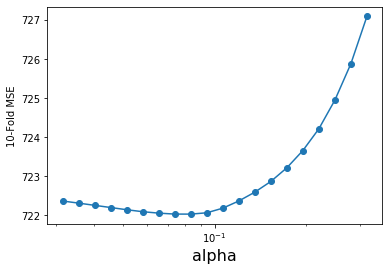

In [97]:
# Código obtenido de notebook 3.3 Selección de características (wrapper y embedded)
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

alpha_vector = np.logspace(-1.5,-0.5,20)
# alpha_vector = np.logspace(-1,-0.25,20)

param_grid = {'alpha': alpha_vector }
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = 10)
grid.fit(XtrainScaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector,scores,'-o')
plt.xlabel('alpha',fontsize=16)
plt.ylabel('10-Fold MSE')
plt.show()

### 5.1.2 Validación

In [98]:
df_test = pd.read_csv('./test.csv', sep=';', decimal='.')

# Realizamos a test todas las transformaciones realizadas a train, con la medias y demás factores de train
df_test = drop_columns_and_filter_rows_in_test_set(df_test, df_turistico)

In [99]:
# Comparamos dataframes de train y test
print(df.shape, df_test.shape)

(10331, 29) (2600, 29)


In [100]:
df_test.describe().T

count        mean         std        min  \
Price                    2600.0   62.176923   43.800962   9.000000   
Host Response Time       2600.0   62.398499    1.560089  58.042834   
Host Response Rate       2600.0   82.557308   34.828815   0.000000   
Host Verifications       2600.0    4.108462    1.318967   1.000000   
Neighbourhood Cleansed   2600.0   61.557459   15.517902  18.500000   
Latitude                 2600.0   40.420933    0.020971  40.331888   
Longitude                2600.0   -3.697286    0.023647  -3.785982   
Property Type            2600.0   62.158530    5.986995  20.500000   
Room Type                2600.0   62.244876   24.516607  28.089041   
Bathrooms                2600.0    1.225065    0.537126   0.000000   
Bedrooms                 2600.0    1.274370    0.746583   0.000000   
Beds                     2600.0    1.931311    1.372483   1.000000   
Bed Type                 2600.0   62.374974    1.432142  43.666667   
Amenities                2600.0   14.310000    4.692226   1.000000   
Security Deposit         2600.0   72.228846  104.605451   0.000000   
Cleaning Fee             2600.0   15.724615   18.839624   0.000000   
Guests Included          2600.0    1.586154    1.092966   1.000000   
Extra People             2600.0    7.096923    8.666307   0.000000   
Minimum Nights           2600.0    2.673077    5.296231   1.000000   
Maximum Nights           2600.0  841.926538  464.578742   1.000000   
Availability 365         2600.0  204.260385  126.617472   0.000000   
Number of Reviews        2600.0   22.919231   38.894590   0.000000   
Review Scores Value      2600.0    9.226481    0.812917   2.000000   
Cancellation Policy      2600.0   62.474490    6.316432  54.523951   
Features                 2600.0    3.733077    1.033631   1.000000   
Years                    2600.0    5.654231    1.628922   3.000000   
bed_bath_rooms           2600.0    1.702511    1.784810   0.000000   
bedrooms_squared         2600.0    2.181189    2.994568   0.000000   
mean_touristic_distance  2600.0    4.729812    1.627065   3.549237   

                                25%          50%          75%          max  
Price                     30.000000    50.000000    79.000000   300.000000  
Host Response Time        62.460938    63.086260    63.086260    63.086260  
Host Response Rate        90.000000   100.000000   100.000000   100.000000  
Host Verifications         3.000000     4.000000     5.000000     9.000000  
Neighbourhood Cleansed    51.441176    61.728571    74.208625   104.383333  
Latitude                  40.409927    40.419103    40.428167    40.513673  
Longitude                 -3.707895    -3.701709    -3.693630    -3.573613  
Property Type             64.073259    64.073259    64.073259    79.285714  
Room Type                 32.958035    82.606945    82.606945    82.606945  
Bathrooms                  1.000000     1.000000     1.000000     6.000000  
Bedrooms                   1.000000     1.000000     2.000000     7.000000  
Beds                       1.000000     1.950767     2.000000    16.000000  
Bed Type                  62.581312    62.581312    62.581312    62.581312  
Amenities                 11.000000    14.000000    17.000000    30.000000  
Security Deposit           0.000000     0.000000   150.000000   600.000000  
Cleaning Fee               0.000000    10.000000    25.000000   140.000000  
Guests Included            1.000000     1.000000     2.000000    15.000000  
Extra People               0.000000     0.000000    14.000000    50.000000  
Minimum Nights             1.000000     2.000000     3.000000   185.000000  
Maximum Nights           365.000000  1125.000000  1125.000000  1125.000000  
Availability 365          83.000000   242.000000   321.000000   365.000000  
Number of Reviews          1.000000     8.000000    27.000000   446.000000  
Review Scores Value        9.000000     9.209671    10.000000    10.000000  
Cancellation Policy       54.523951    61.679590    69.704841    69.704841  


In [101]:
data_test = df_test.values

y_test = data_test[:,0:1]     # En la 1ª columna está Price, nuestra variable objetivo
X_test = data_test[:,1:]      

feature_names_test = df_test.columns[1:]

# Escalamos con el scaler de train
XtestScaled = scaler.transform(X_test) 

In [102]:
# Código obtenido de notebook 3.3 Selección de características (wrapper y embedded)
from sklearn.metrics import mean_squared_error 

alpha_optimo = grid.best_params_['alpha']
lasso = Lasso(alpha = alpha_optimo).fit(XtrainScaled,y_train)

ytrainLasso = lasso.predict(XtrainScaled)
ytestLasso  = lasso.predict(XtestScaled)
mseTrainModelLasso = mean_squared_error(y_train,ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test,ytestLasso)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

w = lasso.coef_
for f,wi in zip(feature_names_test,w):
    print(f,wi)

MSE Modelo Lasso (train): 715
MSE Modelo Lasso (test) : 785
RMSE Modelo Lasso (train): 26.7
RMSE Modelo Lasso (test) : 28
Host Response Time -0.22053629192723873
Host Response Rate -2.211645301688404
Host Verifications -1.0086033573846291
Neighbourhood Cleansed 8.810216664547832
Latitude -0.17499092374641328
Longitude 0.4609207801991967
Property Type -0.0
Room Type 15.381417813965133
Bathrooms 0.0
Bedrooms 12.533869887306041
Beds 3.32238250482683
Bed Type 0.5894910545588914
Amenities 1.4904510748097022
Security Deposit 0.7195901463123466
Cleaning Fee 5.289729231342077
Guests Included 4.0966853656740225
Extra People -2.3732560456868628
Minimum Nights -0.3264926081906502
Maximum Nights -0.17195942374962825
Availability 365 3.2190684425352174
Number of Reviews -4.122338263503401
Review Scores Value 1.4830443076944062
Cancellation Policy -1.2858825705327657
Features 1.1450502051034832
Years 1.1625862496183834
bed_bath_rooms 9.72647853094913
bedrooms_squared -9.022355180868432
mean_touristi

### 5.1.3 Conclusión
El error RMSE en test es de 28 y teniendo en cuenta que la media de precio es 62.37, la predicción no es muy buena.
Se puede comprobar que la combinación habitaciones-baño influye mucho; es curioso, pero los baños no influyen nada.

El tipo de propiedad no influye nada. Sin embargo, lo que más influye es el número de habitaciones (más que habitaciones^2, que además va en sentido contrario -tal vez sea mejor quitar esta característica-) y el barrio, como era de esperar. También tiene su influencia la tasa de limpieza y el número de invitados incluidos. La distancia media a los puntos turísticos influye relativamente poco, -0.11, y como habíamos supuesto, más mayor es (más lejos está la vivienda), menor es el precio.

Sin las tres características finales, el error obtenido es ligeramente mayor:

MSE Modelo Lasso (train): 729  
MSE Modelo Lasso (test) : 799  
RMSE Modelo Lasso (train): 27  
RMSE Modelo Lasso (test) : 28.3  
Host Response Time -0.22492518256175065  
Host Response Rate -2.260980291731021  
Host Verifications -1.0698560749079038  
Neighbourhood Cleansed 8.886784444972966  
Latitude -0.22466938808026737  
Longitude 0.5729557167692154    
Property Type -0.05516398362416161  
Room Type 15.28706289774098  
Bathrooms 3.915126926311151  
Bedrooms 10.826147955629017  
Beds 3.2504473281607784  
Bed Type 0.6966757553078896  
Amenities 1.5963171268181042  
Security Deposit 0.7499122843778413  
Cleaning Fee 5.561428606449561  
Guests Included 4.129756891209097  
Extra People -2.359080996790008  
Minimum Nights -0.40901903147716345  
Maximum Nights -0.3380245232437117  
Availability 365 3.3595709782264374  
Number of Reviews -4.216425387995285  
Review Scores Value 1.6497644738647648  
Cancellation Policy -1.4265403733968238  
Features 1.192474194528762  
Years 1.2647426897170133  


## 5.2 Gradient Boosting Regressor

### 5.2.1 Creación de modelo

NOTA: El siguiente código tarda unos 40 minutos en ejecutarse

In [103]:
# Código de notebook 6. Boosted Trees
from sklearn.ensemble import GradientBoostingRegressor

# Niterations = [500,1000,1500,2000]
# learningRate = [0.1,0.05]
Niterations = [500, 1000, 5000, 8000]
learningRate = [0.1, 0.01]

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth=3), param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.714
best parameters: {'learning_rate': 0.1, 'n_estimators': 500}


### 5.2.2 Validación de modelo

MSE Modelo GradientBoostingRegressor (train): 322
MSE Modelo GradientBoostingRegressor (test) : 548
RMSE Modelo GradientBoostingRegressor (train): 17.9
RMSE Modelo GradientBoostingRegressor (test) : 23.4


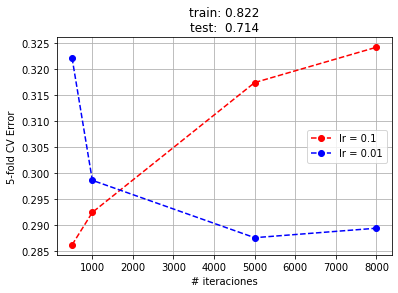

In [104]:
# Código de notebook 6. Boosted Trees
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']

bt = GradientBoostingRegressor(random_state=0, max_depth=3,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(X_train,y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)
    
ytrainBT = bt.predict(X_train)
ytestBT  = bt.predict(X_test)
mseTrainModelBT = mean_squared_error(y_train,ytrainBT)
mseTestModelBT = mean_squared_error(y_test,ytestBT)

print('MSE Modelo GradientBoostingRegressor (train): %0.3g' % mseTrainModelBT)
print('MSE Modelo GradientBoostingRegressor (test) : %0.3g' % mseTestModelBT)

print('RMSE Modelo GradientBoostingRegressor (train): %0.3g' % np.sqrt(mseTrainModelBT))
print('RMSE Modelo GradientBoostingRegressor (test) : %0.3g' % np.sqrt(mseTestModelBT))

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train,y_train),bt.score(X_test,y_test)))
plt.grid()
plt.show()

### 5.2.3 Importancia y dependencia

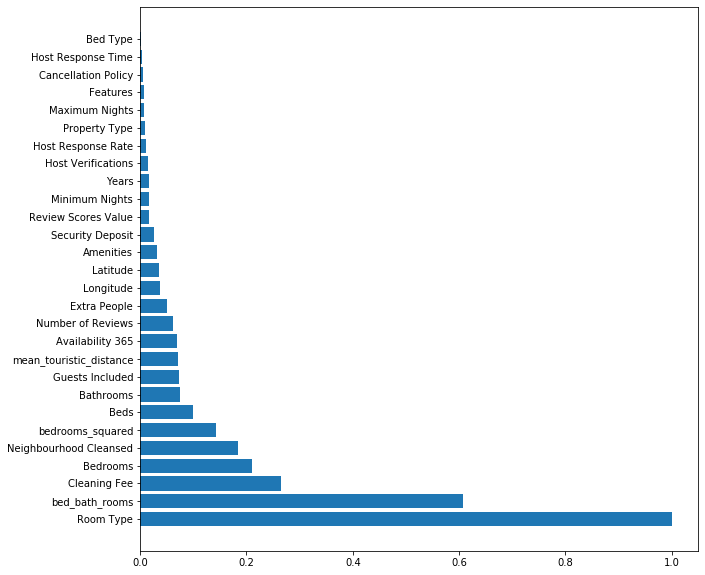

In [105]:
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()

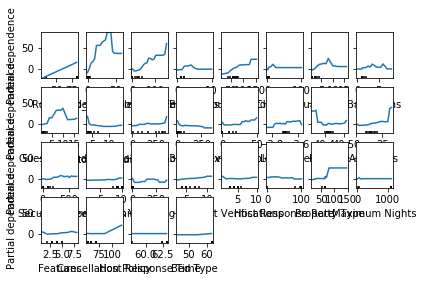

In [106]:
from sklearn.inspection import plot_partial_dependence
fig = plot_partial_dependence(bt, X_train, indices, feature_names=feature_names,
                                 percentiles=(0.0, 1.0), n_cols = 8, grid_resolution=20)

plt.tight_layout()
plt.show()

### 5.2.4 Conclusión

Al igual que en Lasso, las características más importantes son el tipo de habitación, la combinación habitaciónes-baños. la tasa de limpieza, el barrio y habitaciones, aunque no en el mismo orden (en Lasso las más importantes son el tipo de habitación y las habitaciones). Ambos modelos parecen ser similares. En el Gradient Boosted Regressor obtenemos un score de test de 0.714.

## 5.3 Random Forest


### 5.3.1 Creación de modelo

best mean cross-validation score: 0.717
best parameters: {'max_depth': 23}


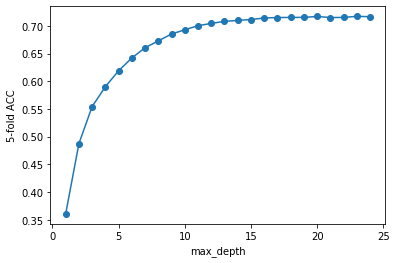

In [107]:
# Código de Notebook 5. Bagging y Random Forest
from sklearn.ensemble import RandomForestRegressor

# grid search
maxDepth = range(1,25)
tuned_parameters = {'max_depth': maxDepth}

rfr = GridSearchCV(RandomForestRegressor(random_state=0
                                         , n_estimators=200, max_features='sqrt'), param_grid=tuned_parameters,cv=5) 
rfr.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(rfr.best_score_))
print("best parameters: {}".format(rfr.best_params_))

scores = np.array(rfr.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth')
plt.ylabel('5-fold ACC')

plt.show()

### 5.3.2 Validación de modelo

In [108]:
# Aunque el maxDepth óptimo se indica que es 24, vemos que a partir de 15 no mejora considerablemente el score
maxDepthOptimo = 15
bagModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))
print("Test: ",bagModel.score(X_test,y_test))

Train:  0.9236815621411085
Test:  0.6963126744066673


In [109]:
# Probemos ahora con 24
maxDepthOptimo = 24
bagModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt').fit(X_train,y_train)

print("Train: ",bagModel.score(X_train,y_train))
print("Test: ",bagModel.score(X_test,y_test))


Train:  0.9606366961000462
Test:  0.6971122677134867


Vemos que entes tenemos un 0.703 con maxDepth 24, frente a un 0.694 de maxDepth = 15. La diferencia no es muy alta.
Podríamos quedamos con un maxDepth 15 porque exige menos proceso, pero dado que la diferencia en tiempo del 
procesado con 24 no es muy diferente, elegiremos 24, para el siguiente paso de importación de variables. No habrá mucha diferencia.

### 5.3.3 Importancia y dependencia

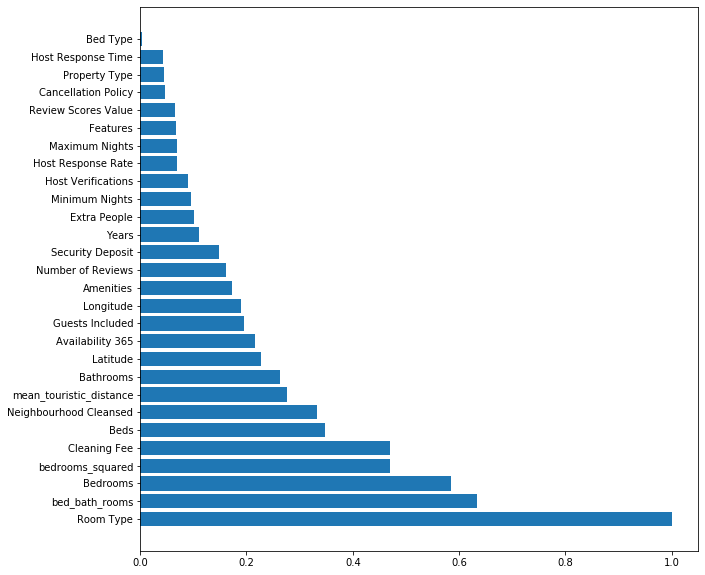

In [110]:
importances = bagModel.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()

### 5.3.4 Selección de características

Las características más importante son el tipo de habitación, la combinación habitaciónes-baños, habitaciones^2, la tasa de limpieza, habitaciones, el barrio y camas.

A continuación, vamos a realizar una selección de características de forma iterativa y calculando para número de características seleccionadas su error y desviación estándar siguiendo el ejemplo del notebook *5. Bagging y Random Forest*. Un código similar al de la siguiente celda podríamos haberlo ejecutado también en los anteriores modelos. La ejecucicón del siguiente código dura unos 25 minutos.

In [111]:
from sklearn.model_selection import KFold

N,Nfeatures = X_train.shape

print(f'X_train.shape {X_train.shape}')

rf = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt')
kf  = KFold(n_splits=10, shuffle = True, random_state=1)
cv_error = []
cv_std = []

for nfeatures in range(Nfeatures,0,-1):
        
    error_i = []
    
    for idxTrain, idxVal in kf.split(X_train):
        
        Xt = X_train[idxTrain,:]
        yt = y_train[idxTrain]
        Xv = X_train[idxVal,:]
        yv = y_train[idxVal]
        
        rf.fit(Xt,yt)
        
        ranking = rf.feature_importances_
        indices = np.argsort(ranking)[::-1] 
    
        selected = indices[0:(Nfeatures-nfeatures+1)]
        
        Xs = Xt[:,selected]
        
        rf.fit(Xs,yt)
        error = (1.0-rf.score(Xv[:,selected],yv))     
        error_i.append(error) 
    
    cv_error.append(np.mean(error_i))
    cv_std.append(np.std(error_i))
    
    print('# features ' + str(len(selected)) + ' error ' + str(np.mean(error_i)) + ' +/- ' + str(np.std(error_i)))

X_train.shape (10331, 28)
# features 1 error 0.6691578932162161 +/- 0.02173273669302424
# features 2 error 0.4471343033822933 +/- 0.04616967473664607
# features 3 error 0.445327283636119 +/- 0.03833866170516681
# features 4 error 0.42537363120489785 +/- 0.036292233786208807
# features 5 error 0.40153756096908266 +/- 0.04081621081557414
# features 6 error 0.39490246713272725 +/- 0.03271148466570813
# features 7 error 0.3848610337352774 +/- 0.03856014311276746
# features 8 error 0.3665309413727417 +/- 0.028406861064904684
# features 9 error 0.3580603601054265 +/- 0.029676143563235904
# features 10 error 0.3450389048184852 +/- 0.028982087452904277
# features 11 error 0.32191731685932046 +/- 0.02882403603802399
# features 12 error 0.3065402682784311 +/- 0.026741530804751442
# features 13 error 0.30243405011368074 +/- 0.0270735459577007
# features 14 error 0.2996228564999054 +/- 0.025502914480007216
# features 15 error 0.29174003603268095 +/- 0.02823259197882306
# features 16 error 0.288572

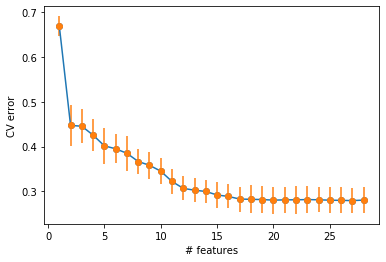

In [112]:
plt.plot(range(1,Nfeatures+1,1),cv_error,'-o')
plt.errorbar(range(1,Nfeatures+1,1), cv_error, yerr=cv_std, fmt='o')
plt.xlabel('# features')
plt.ylabel('CV error')
plt.show()

In [113]:
# Del gráfico anterior podemos deducir que más o menos a partir de 18-19 características el error se mantiene igual.

selected_features = indices[0:19]


bagModel = RandomForestRegressor(max_depth=maxDepthOptimo,n_estimators=200,max_features='sqrt')
bagModel.fit(X_train[:, selected_features],y_train)

print("Train: ",bagModel.score(X_train[:, selected_features],y_train))
print("Test: ",bagModel.score(X_test[:, selected_features],y_test))

ytrainRFR = bagModel.predict(X_train[:, selected_features])
ytestRFR  = bagModel.predict(X_test[:, selected_features])
mseTrainModelRFR = mean_squared_error(y_train,ytrainRFR)
mseTestModelRFR = mean_squared_error(y_test,ytestRFR)

print('MSE Modelo RandomForestRegressor (train): %0.3g' % mseTrainModelRFR)
print('MSE Modelo RandomForestRegressor (test) : %0.3g' % mseTestModelRFR)

print('RMSE Modelo RandomForestRegressor (train): %0.3g' % np.sqrt(mseTrainModelRFR))
print('RMSE Modelo RandomForestRegressor (test) : %0.3g' % np.sqrt(mseTestModelRFR))

Train:  0.961110534196827
Test:  0.697376411836109
MSE Modelo RandomForestRegressor (train): 70.2
MSE Modelo RandomForestRegressor (test) : 580
RMSE Modelo RandomForestRegressor (train): 8.38
RMSE Modelo RandomForestRegressor (test) : 24.1


### 5.3.5 Conclusión

Las características más importantes, muy parecidas al modelo anterior, son el tipo de habitación, la combinación habitaciónes-baños, habitaciones^2, la tasa de limpieza, habitaciones, el barrio y camas, aunque no en el mismo orden (en Lasso las más importantes son el tipo de habitación y las habitaciones). Ambos modelos parecen ser similares. El score que obtenemos es un poco más pequeño que en Gradient Boosted, pero podemos considerarlos casi iguales, aunque el RMSE es mejor en el Gradient Boosting Regressor, 23.4, que en el Random Forest, 24.1.

# 6 Conclusión final

Los tres modelos examinados arrojan unos datos similares.
<table>
    <tr>
        <th></th><th>Lasso</th><th>Gradient Boosting</th><th>Random Forest</th>
    </tr>
    <tr>
        <td>MSE</td><td>785</td><td>548</td><td>579</td>
    </tr>
    <tr>
        <td>RMSE</td><td>28</td><td>23.4</td><td>24.1</td>
    </tr>
</table>
Se deduce que el mejor modelo, por muy poco, es el Gradient Boosting, aunque podemos considerarlo casi igual que el Random Forest.

También se llega a la conclusión, que en lugar de utilizar todas las características, podemos utilizar las 18-19 primeras (tal vez, las 15 ó 16 primeras). Los predicciones realizadas con las caracterítiscas añadidas, relación baños-habitaciones, habitacion^2 y distancia media a puntos de interés turístico de Madrid, mejoran ligeramente algún modelo, aunque no de forma sustancial (incluso alguno tiene peor RMSE)

La práctica ha sido un primer estudio de los datos y quedarían tareas por hacer, algunas de las cuales han sido marcada en este notebook como TODOs. Por ejemplo

- dado que el precio sigue una distribución logarítmica, habría que hacer un estudio sobre su logaritmo, que sigue una distribucción gaussiana.
- Se podrían probar más modelos, como, por ejemplo, SVM
- Habría que estudiar más la relación entre Price y Cleaning fee
- Se deberían estudiar con más detenimiento los valores de las listas de Amenities, Features y Host Verifications y comprobar  si algunos de estos valores o combinación de ellos influyen en el precio.
- Se deberían investigar más combinaciones de características y añadir otras nuevas conocimiento más el modelo de negocio de Airbnb.
- Asimismo habría que incluir en el estudios las variables de tipo URL analizando las páginas web o imágenes a las que dirigen. De estas páginas web o images se podría obtener más información que podríamos convertirla en más características, que, probablemnte, nos ayudarían a mejorar la predicción del precio.

